In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime

In [2]:
xr.set_options(display_style='text')

In [3]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# # terrain_file = f'{iclassdir}corgridded_terrain.c0/CSAPR2_Taranis_Gridded_500m.Terrain_RangeMask.nc'
# # terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2.nc'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# # stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'

iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_mpgridded_celltracking.c1/stats/'
# stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/stats_mpgrid/celltrack_stats/'
os.makedirs(figdir, exist_ok=True)

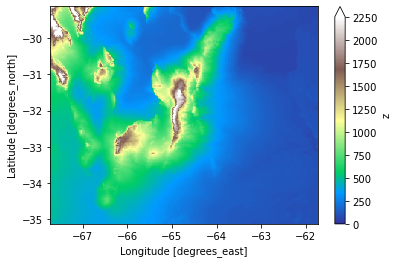

In [4]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [5]:
# stats = xr.open_dataset(stats_file)
# stats.dims['tracks']

# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6895

In [6]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [7]:
# Combine datasets by coordinates
stats = xr.combine_by_coords([stats2d, sat], combine_attrs='override')
stats.load()
print(stats)

<xarray.Dataset>
Dimensions:                    (times: 60, tracks: 6895)
Coordinates:
  * tracks                     (tracks) int32 0 1 2 3 4 ... 6891 6892 6893 6894
  * times                      (times) int32 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
Data variables: (12/56)
    cloud_top_temperature_min  (tracks, times) float32 nan nan nan ... nan nan
    temperature_ir_min         (tracks, times) float32 301.0 302.3 ... nan nan
    cloud_top_height_max       (tracks, times) float32 0.0 0.0 nan ... nan nan
    cloud_top_pressure_min     (tracks, times) float32 nan nan nan ... nan nan
    area_liquid                (tracks, times) float32 0.0 0.0 nan ... nan nan
    area_ice                   (tracks, times) float32 0.0 0.0 nan ... nan nan
    ...                         ...
    end_merge_timeindex        (tracks) float64 nan nan nan nan ... 1.0 nan nan
    end_merge_cloudnumber      (tracks) float64 nan nan nan nan ... 1.0 nan nan
    merge_tracknumbers         (tracks, times) float64 nan

In [8]:
tracks = stats['tracks']
times = stats['times']

lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxrange_flag = stats['maxrange_flag']

maxdbz = stats['maxdbz']
eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

ctt = stats['cloud_top_temperature_min']
cth = stats['cloud_top_height_max']

In [9]:
stats.sizes

Frozen(SortedKeysDict({'tracks': 6895, 'times': 60}))

In [10]:
# Get cell initial location
cell_lon0 = cell_lon.isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

Number of valid tracks: 6887


In [11]:
# Subset tracks
lifetime = lifetime.isel(tracks=ind)
start_time = start_time.isel(tracks=ind)
end_time = end_time.isel(tracks=ind)
end_merge_tracknumber = end_merge_tracknumber.isel(tracks=ind)
start_split_tracknumber = start_split_tracknumber.isel(tracks=ind)
cell_lon = cell_lon.isel(tracks=ind)
cell_lat = cell_lat.isel(tracks=ind)
cell_area = cell_area.isel(tracks=ind)
maxrange_flag = maxrange_flag.isel(tracks=ind)
maxdbz = maxdbz.isel(tracks=ind)
eth10 = eth10.isel(tracks=ind)
eth20 = eth20.isel(tracks=ind)
eth30 = eth30.isel(tracks=ind)
eth40 = eth40.isel(tracks=ind)
eth50 = eth50.isel(tracks=ind)

ctt = ctt.isel(tracks=ind)
cth = cth.isel(tracks=ind)

In [12]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

(array([ 868.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6019.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

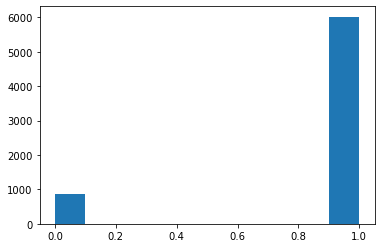

In [13]:
plt.hist(end_maxrange_flag, bins=np.arange(0,1.01,0.1))

In [14]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

In [15]:
# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of non-split tracks within max range: 4854
Number of non-merge tracks within max range: 4528
Number of merge tracks: 1603
Number of split tracks: 1528


In [16]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)
# hist_starthour, bins = np.histogram(start_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
# hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# hist_endhour, bins = np.histogram(end_hour.isel(tracks=nonmerge), bins=hour_bin, range=(0,24), density=False)
# hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_starthour, bins = np.histogram(start_hour, bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour, bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Initiation E.SDC vs. W.SDC
lon_SDC = -65
hist_starthour_eSDC, bins = np.histogram(start_hour.where(start_lon > lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)
hist_starthour_wSDC, bins = np.histogram(start_hour.where(start_lon <= lon_SDC, drop=True), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-3)
hist_starthour_LT = np.roll(hist_starthour, -3)
hist_starthour_in_LT = np.roll(hist_starthour_in, -3)

hist_endhour_LT = np.roll(hist_endhour, -3)
hist_endhour_in_LT = np.roll(hist_endhour_in, -3)

hist_starthour_eSDC_LT = np.roll(hist_starthour_eSDC, -3)
hist_starthour_wSDC_LT = np.roll(hist_starthour_wSDC, -3)

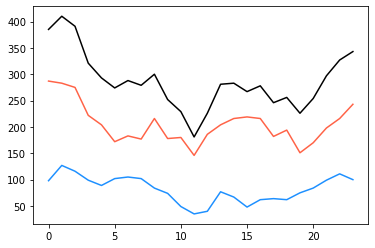

In [17]:
plt.plot(bins[:-1], hist_starthour_LT, color='k')
plt.plot(bins[:-1], hist_starthour_eSDC_LT, color='tomato')
plt.plot(bins[:-1], hist_starthour_wSDC_LT, color='dodgerblue')

In [18]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_area_max = cell_area.max(dim='times')
cell_eth20_max = eth20.max(dim='times')
cell_maxdbz_max = maxdbz.max(dim='times')
cell_minctt_min = ctt.min(dim='times')

(array([ 193.,  976., 1706., 1735., 1069.,  653.,  284.,  151.,   54.,
          14.]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

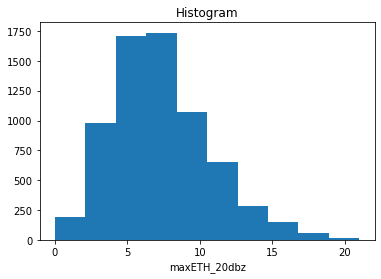

In [19]:
cell_eth20_max.plot.hist()

In [20]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_max_hourbin = []
cell_diam_max_hourbin = []
cell_eth20_max_hourbin = []
cell_maxdbz_max_hourbin = []
cell_minctt_min_hourbin = []
for ihour in range(24):
    cell_area_max_hourbin.append(np.log10(cell_area_max.where(start_hour == ihour, drop=True)).values)
    cell_diam_max_hourbin.append(cell_diam_max.where(start_hour == ihour, drop=True).values)
    cell_eth20_max_hourbin.append(cell_eth20_max.where((start_hour == ihour) & (~np.isnan(cell_eth20_max)), drop=True).values)
    cell_maxdbz_max_hourbin.append(cell_maxdbz_max.where((start_hour == ihour) & (~np.isnan(cell_maxdbz_max)), drop=True).values)
    cell_minctt_min_hourbin.append(cell_minctt_min.where((start_hour == ihour) & (~np.isnan(cell_minctt_min)), drop=True).values)

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_max_hourbin = np.array(cell_diam_max_hourbin, dtype=object, copy=False, subok=True)
cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
cell_area_max_hourbin = np.array(cell_area_max_hourbin, dtype=object, copy=False, subok=True)
cell_area_max_hourbin_LT = np.roll(cell_area_max_hourbin, -3)
cell_eth20_max_hourbin = np.array(cell_eth20_max_hourbin, dtype=object, copy=False, subok=True)
cell_eth20_max_hourbin_LT = np.roll(cell_eth20_max_hourbin, -3)
cell_maxdbz_max_hourbin = np.array(cell_maxdbz_max_hourbin, dtype=object, copy=False, subok=True)
cell_maxdbz_max_hourbin_LT = np.roll(cell_maxdbz_max_hourbin, -3)
cell_minctt_min_hourbin = np.array(cell_minctt_min_hourbin, dtype=object, copy=False, subok=True)
cell_minctt_min_hourbin_LT = np.roll(cell_minctt_min_hourbin, -3)

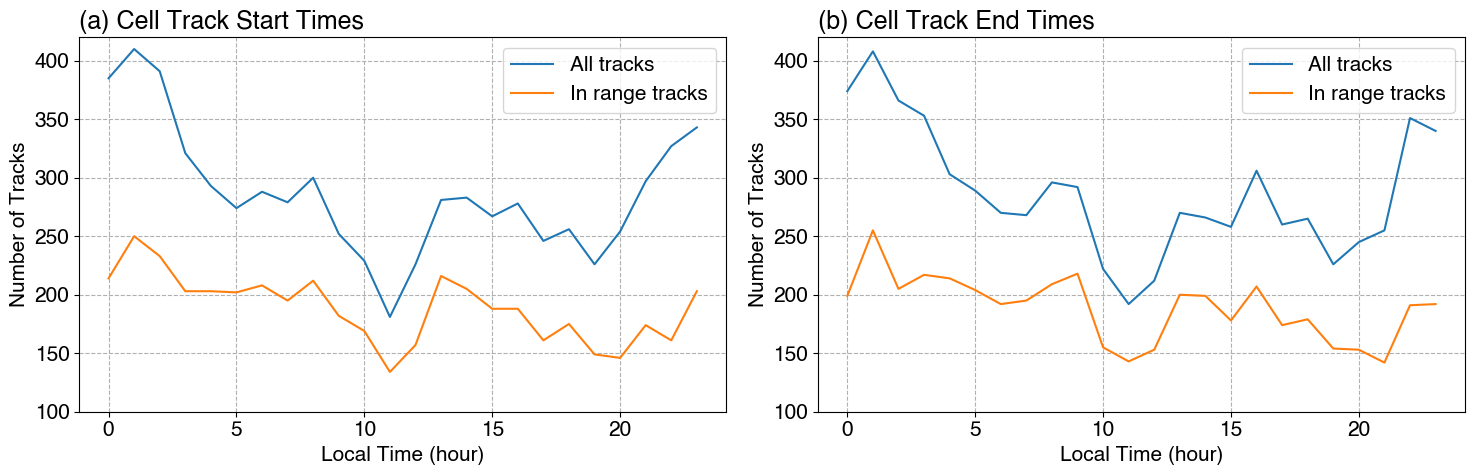

In [21]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=[15,5], dpi=100)

ax1 = axes[0]
ax1.plot(hour_bin[:-1], hist_starthour_LT, label='All tracks')
ax1.plot(hour_bin[:-1], hist_starthour_in_LT, label='In range tracks')
ax1.legend()
ax1.grid(ls='--')
ax1.set_title('(a) Cell Track Start Times', loc='left')
ax1.set_ylabel('Number of Tracks')
ax1.set_xlabel('Local Time (hour)')
ax1.set_ylim(100, 420)

ax2 = axes[1]
ax2.plot(hour_bin[:-1], hist_endhour_LT, label='All tracks')
ax2.plot(hour_bin[:-1], hist_endhour_in_LT, label='In range tracks')
ax2.legend()
ax2.grid(ls='--')
ax2.set_title('(b) Cell Track End Times', loc='left')
ax2.set_ylabel('Number of Tracks')
ax2.set_xlabel('Local Time (hour)')
ax2.set_ylim(100, 420)

fig.tight_layout()

In [22]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
# plt.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, ls='--', label='E.SDC')
# ax1.legend(loc='upper left', ncol=2)
# ax1.grid(ls='--')
# ax1.set_title('Cell Track Diurnal Cycle', loc='left')
# ax1.set_ylabel('Number of Tracks')
# ax1.set_xlabel('Local Time (hour)')
# ax1.set_ylim(100, 450)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)
# ax1.yaxis.label.set_color('tomato')
# ax1.tick_params(axis='y', colors='tomato')

# boxprops_ = dict(linestyle='-', linewidth=0, color='k', facecolor='dodgerblue', alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
# meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

# ax2 = ax1.twinx()
# bp1 = ax2.boxplot(cell_diam_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax2.set_ylabel('Cell Max Diameter (km)', color='dodgerblue')
# ax2.set_ylim(4, 16)
# ax2.tick_params(axis='y', labelcolor='dodgerblue')

# ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax2
# ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
# ax1.spines['left'].set_color('tomato')
# ax1.spines['right'].set_color('dodgerblue')

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxdiam_boxplot.png', bbox_inches='tight', dpi=300)

In [24]:
# hist_starthour_eSDC_LT_frac = 100 * (hist_starthour_eSDC_LT / hist_starthour_LT)
# plt.plot(hour_binv, hist_starthour_eSDC_LT_frac)

In [25]:
# idx12_18 = np.where((hour_binv >= 12) & (hour_binv <= 18))
# 100 * (np.sum(hist_starthour_eSDC_LT[idx12_18]) / np.sum(hist_starthour_LT[idx12_18]))

In [26]:
# mpl.rcParams['font.size'] = 17
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(2, 1, figsize=[10,10], dpi=100)
# sonde_times = [9,12,15,18,21]

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes[0]
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
# # ax1.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, ls='--', label='E.SDC')
# ax1.legend(loc='upper right', ncol=2)
# ax1.grid(ls='--')
# ax1.set_title('(a) Cell Track Area', loc='left')
# ax1.set_ylabel('Number of Cell Initiation (All)')
# ax1.set_ylim(150, 450)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)
# ax1.yaxis.label.set_color('tomato')
# ax1.tick_params(axis='y', colors='tomato')
# for ll in range(len(sonde_times)):
#     ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
# ax1.text(8.5, 430, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# boxprops_ = dict(linestyle='-', linewidth=0, color='k', facecolor='dodgerblue', alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
# meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

# ax1b = ax1.twinx()
# bp1 = ax1b.boxplot(cell_area_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax1b.set_ylabel('Log$_{10}$(Cell Max Area (km$^2$))', color='dodgerblue')
# ax1b.set_ylim(1.2, 2.4)
# ax1b.tick_params(axis='y', labelcolor='dodgerblue')
# ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax1b
# ax1.patch.set_visible(False)  # prevents ax1 from hiding ax1b
# ax1.spines['left'].set_color('tomato')
# ax1.spines['right'].set_color('dodgerblue')
# # Annotate
# ax1b.annotate("", xy=(18, 1.95), xytext=(12, 1.65), arrowprops=dict(facecolor='black'))
# ax1b.text(18, 2, 'Area Growth', ha='center', fontsize=18, fontweight='bold')


# #-----------------------------------------------
# ax2 = axes[1]
# # ax2.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
# ax2.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, label='E.SDC')
# ax2.legend(loc='upper right', ncol=2)
# ax2.grid(ls='--')
# ax2.set_title('(b) Cell Track Echo-Top Height', loc='left')
# ax2.set_ylabel('Number of Cell Initiation (E.SDC)')
# ax2.set_xlabel('Local Time (hour, UTC-3)')
# ax2.set_ylim(130, 300)
# ax2.set_xticks(np.arange(0,24.1,3))
# ax2.set_xlim(0,24)
# ax2.yaxis.label.set_color('tomato')
# ax2.tick_params(axis='y', colors='tomato')
# for ll in range(len(sonde_times)):
#     ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
# ax2.text(8.5, 285, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# barcolor = 'lightseagreen'
# boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
# meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

# ax2b = ax2.twinx()
# bp1 = ax2b.boxplot(cell_eth20_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax2b.set_ylabel('Cell Max 20dBZ ETH (km)', color=barcolor)
# ax2b.set_ylim(2, 16)
# ax2b.tick_params(axis='y', labelcolor=barcolor)
# ax2.set_zorder(2)  # default zorder is 0 for ax2 and ax2b
# ax2.patch.set_visible(False)  # prevents ax2 from hiding ax2b
# ax2.spines['left'].set_color('tomato')
# ax2.spines['right'].set_color(barcolor)
# # Annotate
# ax2b.annotate("", xy=(18, 10.5), xytext=(12, 7), arrowprops=dict(facecolor='black'))
# ax2b.text(18, 11.5, 'Deepening', ha='center', fontsize=18, fontweight='bold')

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxarea_max20dbzETH_boxplot.png', bbox_inches='tight', facecolor='w', dpi=300)

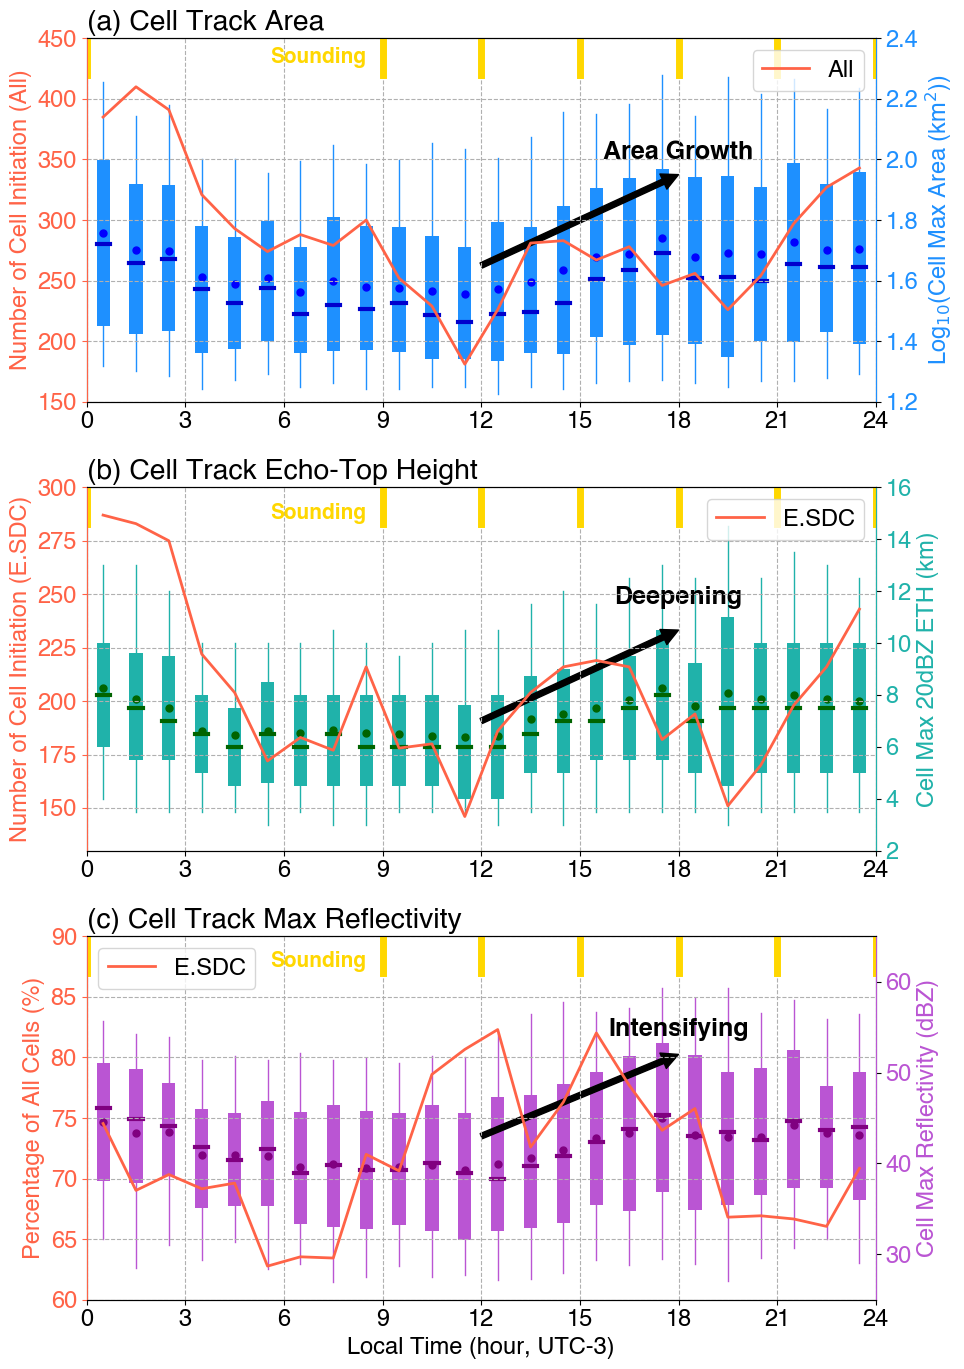

In [27]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['figure.facecolor'] = 'white'
fig, axes = plt.subplots(3, 1, figsize=[10,14], dpi=100)
sonde_times = [0,9,12,15,18,21,24]

hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
ax1 = axes[0]
ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
# ax1.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, ls='--', label='E.SDC')
ax1.legend(loc='upper right', ncol=2)
ax1.grid(ls='--')
ax1.set_title('(a) Cell Track Area', loc='left')
ax1.set_ylabel('Number of Cell Initiation (All)')
ax1.set_ylim(150, 450)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlim(0,24)
ax1.yaxis.label.set_color('tomato')
ax1.tick_params(axis='y', colors='tomato')
for ll in range(len(sonde_times)):
    ax1.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax1.text(8.5, 430, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

boxprops_ = dict(linestyle='-', linewidth=0, color='k', facecolor='dodgerblue', alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color='dodgerblue')

ax1b = ax1.twinx()
bp1 = ax1b.boxplot(cell_area_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax1b.set_ylabel('Log$_{10}$(Cell Max Area (km$^2$))', color='dodgerblue')
ax1b.set_ylim(1.2, 2.4)
ax1b.tick_params(axis='y', labelcolor='dodgerblue')
ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax1b
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax1b
ax1.spines['left'].set_color('tomato')
ax1.spines['right'].set_color('dodgerblue')
# Annotate
ax1b.annotate("", xy=(18, 1.95), xytext=(12, 1.65), arrowprops=dict(facecolor='black'))
ax1b.text(18, 2, 'Area Growth', ha='center', fontsize=18, fontweight='bold')


#-----------------------------------------------
ax2 = axes[1]
# ax2.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
ax2.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, label='E.SDC')
ax2.legend(loc='upper right', ncol=2)
ax2.grid(ls='--')
ax2.set_title('(b) Cell Track Echo-Top Height', loc='left')
ax2.set_ylabel('Number of Cell Initiation (E.SDC)')
# ax2.set_xlabel('Local Time (hour, UTC-3)')
ax2.set_ylim(130, 300)
ax2.set_xticks(np.arange(0,24.1,3))
ax2.set_xlim(0,24)
ax2.yaxis.label.set_color('tomato')
ax2.tick_params(axis='y', colors='tomato')
for ll in range(len(sonde_times)):
    ax2.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax2.text(8.5, 285, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
barcolor = 'lightseagreen'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

ax2b = ax2.twinx()
bp1 = ax2b.boxplot(cell_eth20_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2b.set_ylabel('Cell Max 20dBZ ETH (km)', color=barcolor)
ax2b.set_ylim(2, 16)
ax2b.tick_params(axis='y', labelcolor=barcolor)
ax2.set_zorder(2)  # default zorder is 0 for ax2 and ax2b
ax2.patch.set_visible(False)  # prevents ax2 from hiding ax2b
ax2.spines['left'].set_color('tomato')
ax2.spines['right'].set_color(barcolor)
# Annotate
ax2b.annotate("", xy=(18, 10.5), xytext=(12, 7), arrowprops=dict(facecolor='black'))
ax2b.text(18, 11.5, 'Deepening', ha='center', fontsize=18, fontweight='bold')

#-----------------------------------------------
ax3 = axes[2]
ax3.plot(hour_binv, hist_starthour_eSDC_LT_frac, color='tomato', lw=2, label='E.SDC')
ax3.legend(loc='upper left', ncol=2)
ax3.grid(ls='--')
ax3.set_title('(c) Cell Track Max Reflectivity', loc='left')
ax3.set_ylabel('Percentage of All Cells (%)')
ax3.set_xlabel('Local Time (hour, UTC-3)')
ax3.set_ylim(60, 90)
ax3.set_xticks(np.arange(0,24.1,3))
ax3.set_xlim(0,24)
# ax3.spines['left'].set_color('tomato')
ax3.yaxis.label.set_color('tomato')
ax3.tick_params(axis='y', colors='tomato')
for ll in range(len(sonde_times)):
    ax3.axvline(sonde_times[ll], ymin=0.9, ymax=1, color='gold', lw=5)
ax3.text(8.5, 87.5, 'Sounding', color='gold', ha='right', fontsize=15, fontweight='bold')

barcolor = 'mediumorchid'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='purple')
meanpointprops_ = dict(marker='o', markeredgecolor='purple', markerfacecolor='purple', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

ax3b = ax3.twinx()
bp1 = ax3b.boxplot(cell_maxdbz_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax3b.set_ylabel('Cell Max Reflectivity (dBZ)', color=barcolor)
ax3b.set_ylim(25, 65)
ax3b.tick_params(axis='y', labelcolor=barcolor)

# Annotate
ax3b.annotate("", xy=(18, 52), xytext=(12, 43), arrowprops=dict(facecolor='black'))
ax3b.text(18, 54, 'Intensifying', ha='center', fontsize=18, fontweight='bold')

ax3.set_zorder(2)  # default zorder is 0 for ax3 and ax3b
ax3.patch.set_visible(False)  # prevents ax3 from hiding ax3b
ax3.spines['left'].set_color('tomato')
ax3.spines['right'].set_color(barcolor)

fig.tight_layout()
fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxarea_max20dbzETH_maxdbz_boxplot.png', bbox_inches='tight', facecolor='w', dpi=300)

In [28]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
# plt.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, ls='--', label='E.SDC')
# ax1.legend(loc='upper left', ncol=2)
# ax1.grid(ls='--')
# ax1.set_title('Cell Track Diurnal Cycle', loc='left')
# ax1.set_ylabel('Number of Cell Initiation')
# ax1.set_xlabel('Local Time (hour, UTC-3)')
# ax1.set_ylim(100, 450)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)
# ax1.yaxis.label.set_color('tomato')
# ax1.tick_params(axis='y', colors='tomato')

# barcolor = 'dodgerblue'
# boxprops_ = dict(linestyle='-', linewidth=0, color='k', facecolor=barcolor, alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='mediumblue')
# meanpointprops_ = dict(marker='o', markeredgecolor='b', markerfacecolor='b', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

# ax2 = ax1.twinx()
# bp1 = ax2.boxplot(cell_area_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax2.set_ylabel('Log$_{10}$(Cell Max Area (km$^2$))', color=barcolor)
# ax2.set_ylim(1.2, 2.4)
# ax2.tick_params(axis='y', labelcolor=barcolor)

# # Annotate
# ax2.annotate("", xy=(18, 1.95), xytext=(12, 1.65), arrowprops=dict(facecolor='black'))
# ax2.text(18, 2, 'Area Growth', ha='center', fontsize=18, fontweight='bold')

# ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax2
# ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
# ax1.spines['left'].set_color('tomato')
# ax1.spines['right'].set_color(barcolor)

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxarea_boxplot.png', bbox_inches='tight', dpi=300)

In [29]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
# plt.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, ls='--', label='E.SDC')
# ax1.legend(loc='upper left', ncol=2)
# ax1.grid(ls='--')
# ax1.set_title('Cell Track Diurnal Cycle', loc='left')
# ax1.set_ylabel('Number of Tracks')
# ax1.set_xlabel('Local Time (hour, UTC-3)')
# ax1.set_ylim(100, 450)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)
# # ax1.spines['left'].set_color('tomato')
# ax1.yaxis.label.set_color('tomato')
# ax1.tick_params(axis='y', colors='tomato')

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# barcolor = 'lightseagreen'
# boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor='lightseagreen', alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='darkgreen')
# meanpointprops_ = dict(marker='o', markeredgecolor='darkgreen', markerfacecolor='darkgreen', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color='lightseagreen')

# ax2 = ax1.twinx()
# bp1 = ax2.boxplot(cell_eth20_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax2.set_ylabel('Cell Max 20dBZ ETH (km)', color='lightseagreen')
# ax2.set_ylim(2, 16)
# ax2.tick_params(axis='y', labelcolor='lightseagreen')

# # Annotate
# ax2.annotate("", xy=(18, 10), xytext=(12, 7), arrowprops=dict(facecolor='black'))
# ax2.text(18, 11, 'Deepening', ha='center', fontsize=18, fontweight='bold')

# ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax2
# ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
# ax1.spines['left'].set_color('tomato')
# ax1.spines['right'].set_color('lightseagreen')

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxETH20dbz_boxplot.png', bbox_inches='tight', dpi=300)

In [30]:
# mpl.rcParams['font.size'] = 15
# mpl.rcParams['font.family'] = 'Helvetica'
# mpl.rcParams['figure.facecolor'] = 'white'
# fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# ax1 = axes
# ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
# plt.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, ls='--', label='E.SDC')
# ax1.legend(loc='upper left', ncol=2)
# ax1.grid(ls='--')
# ax1.set_title('Cell Track Diurnal Cycle', loc='left')
# ax1.set_ylabel('Number of Tracks')
# ax1.set_xlabel('Local Time (hour, UTC-3)')
# ax1.set_ylim(100, 450)
# ax1.set_xticks(np.arange(0,24.1,3))
# ax1.set_xlim(0,24)
# # ax1.spines['left'].set_color('tomato')
# ax1.yaxis.label.set_color('tomato')
# ax1.tick_params(axis='y', colors='tomato')

# hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
# barcolor = 'mediumorchid'
# boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
# medianprops_ = dict(linestyle='-', linewidth=3, color='purple')
# meanpointprops_ = dict(marker='o', markeredgecolor='purple', markerfacecolor='purple', markersize=5)
# whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

# ax2 = ax1.twinx()
# bp1 = ax2.boxplot(cell_maxdbz_max_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
#                   boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
#                   showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
# ax2.set_ylabel('Cell Max Reflectivity (dBZ)', color=barcolor)
# ax2.set_ylim(25, 65)
# ax2.tick_params(axis='y', labelcolor=barcolor)

# # Annotate
# ax2.annotate("", xy=(18, 52), xytext=(12, 43), arrowprops=dict(facecolor='black'))
# ax2.text(18, 54, 'Intensifying', ha='center', fontsize=18, fontweight='bold')

# ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax2
# ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
# ax1.spines['left'].set_color('tomato')
# ax1.spines['right'].set_color(barcolor)

# fig.tight_layout()
# fig.savefig(f'{figdir}celltrack_diurnal_startendtime_maxdbz_boxplot.png', bbox_inches='tight', dpi=300)

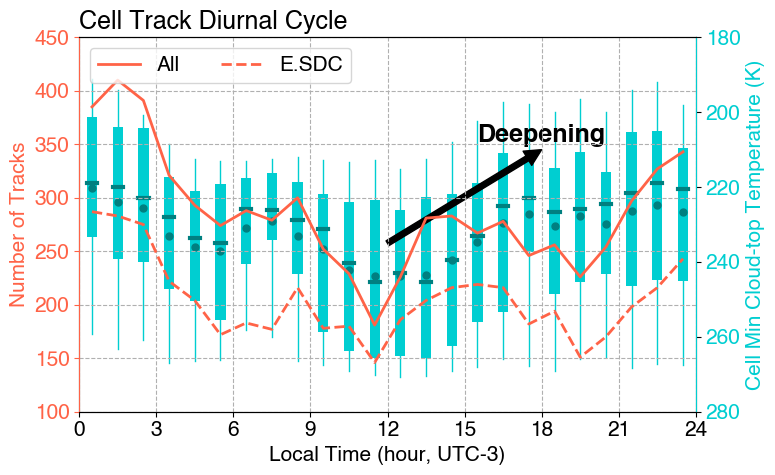

In [41]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
mpl.rcParams['figure.facecolor'] = 'white'
fig, axes = plt.subplots(1, 1, figsize=[8,5], dpi=100)

hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
ax1 = axes
ax1.plot(hour_binv, hist_starthour_LT, color='tomato', lw=2, label='All')
plt.plot(hour_binv, hist_starthour_eSDC_LT, color='tomato', lw=2, ls='--', label='E.SDC')
ax1.legend(loc='upper left', ncol=2)
ax1.grid(ls='--')
ax1.set_title('Cell Track Diurnal Cycle', loc='left')
ax1.set_ylabel('Number of Tracks')
ax1.set_xlabel('Local Time (hour, UTC-3)')
ax1.set_ylim(100, 450)
ax1.set_xticks(np.arange(0,24.1,3))
ax1.set_xlim(0,24)
# ax1.spines['left'].set_color('tomato')
ax1.yaxis.label.set_color('tomato')
ax1.tick_params(axis='y', colors='tomato')

hour_binv = hour_bin[:-1] + np.diff(hour_bin)/2
barcolor = 'darkturquoise'
boxprops_ = dict(linestyle='-', linewidth=0, color='none', facecolor=barcolor, alpha=1)
medianprops_ = dict(linestyle='-', linewidth=3, color='teal')
meanpointprops_ = dict(marker='o', markeredgecolor='teal', markerfacecolor='teal', markersize=5)
whiskerprops_ = dict(linewidth=1, linestyle='-', color=barcolor)

ax2 = ax1.twinx()
bp1 = ax2.boxplot(cell_minctt_min_hourbin_LT, positions=hour_binv, patch_artist=True, widths=0.4, notch=False, manage_ticks=False,
                  boxprops=boxprops_, medianprops=medianprops_, whis=[10,90], whiskerprops=whiskerprops_, 
                  showfliers=False, showmeans=True, meanprops=meanpointprops_, meanline=False, showcaps=False)
ax2.set_ylabel('Cell Min Cloud-top Temperature (K)', color=barcolor)
ax2.set_ylim(280, 180)
ax2.tick_params(axis='y', labelcolor=barcolor)

# Annotate
ax2.annotate("", xy=(18, 210), xytext=(12, 235), arrowprops=dict(facecolor='black'))
ax2.text(18, 208, 'Deepening', ha='center', fontsize=18, fontweight='bold')

ax1.set_zorder(2)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.spines['left'].set_color('tomato')
ax1.spines['right'].set_color(barcolor)

fig.tight_layout()
fig.savefig(f'{figdir}celltrack_diurnal_startendtime_minctt_boxplot.png', bbox_inches='tight', dpi=300)

In [42]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'

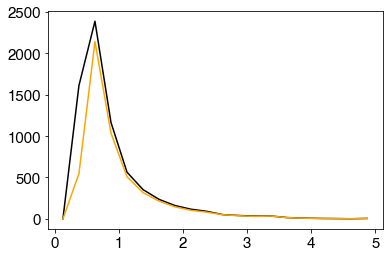

In [27]:
bins_lifetime = np.arange(21)*0.25
bins_lifetime_c = bins_lifetime[:-1] + np.diff(bins_lifetime)/2
hist_lifetime_all, bins = np.histogram(lifetime, bins=bins_lifetime, range=(0,5), density=False)
hist_lifetime_nonmerge, bins = np.histogram(lifetime.isel(tracks=nonmerge), bins=bins_lifetime, range=(0,5), density=False)
plt.plot(bins_lifetime_c, hist_lifetime_all, color='k')
plt.plot(bins_lifetime_c, hist_lifetime_nonmerge, color='orange')

In [28]:
lifetime.mean().values, lifetime.isel(tracks=nonmerge).mean().values

(array(0.75254102), array(0.84107684))

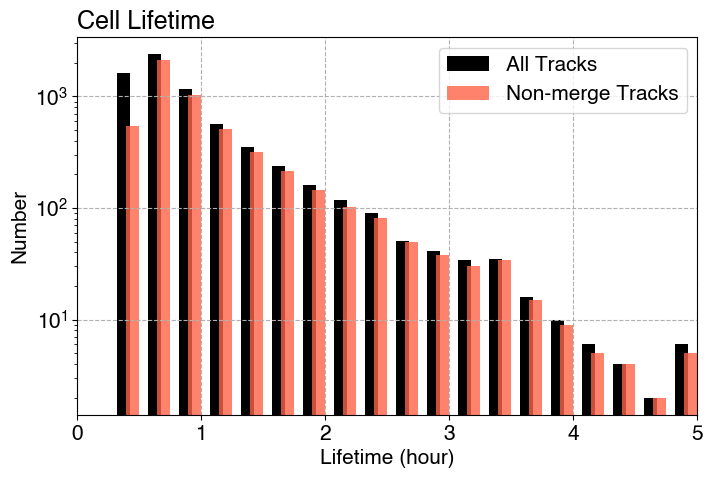

In [29]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Lifetime (hour)')
ax1.set_ylabel('Number')
# ax1.hist(lifetime, bins=np.arange(21)*0.25, density=False, label='All Tracks', width=0.1, color='k')
# ax1.hist(lifetime.isel(tracks=nonmerge), bins=np.arange(21)*0.25, density=False, label='Non-merge Tracks', width=0.2, alpha=0.6)
b1 = ax1.bar(bins_lifetime_c, hist_lifetime_all, width=0.1, color='k', label='All Tracks')
b2 = ax1.bar(bins_lifetime_c+0.07, hist_lifetime_nonmerge, width=0.1, color='tomato', alpha=0.8, label='Non-merge Tracks')
ax1.legend()
ax1.set_xlim(0, 5)
ax1.set_title('Cell Lifetime', loc='left')
ax1.grid(ls='--')
ax1.set_yscale('log')
fig.savefig(f'{figdir}celltrack_lifetime_pdf.png', bbox_inches='tight', dpi=300, facecolor='w')

In [30]:
# lt_bins = np.arange(15)*0.25
# hour_bins = np.arange(9)*3
# plt.hist2d(start_hour, lifetime, bins=[hour_bins, lt_bins], density=False)
# plt.colorbar()

In [31]:
def plot_2heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, cblabels, titles, figname, eSDC=None):
    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'
    fig, axes = plt.subplots(1, 2, figsize=(15,6), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500,1000,1500,2000,2500]

    ax1 = axes[0]
    Zm = np.ma.masked_where(dataarr[0] == 0, dataarr[0])
    cmap = plt.get_cmap(cmaps[0])
    norm = mpl.colors.BoundaryNorm(boundaries=levels[0], ncolors=cmap.N)
    p1 = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p1, ax=ax1, label=cblabels[0])
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.set_title(titles[0], loc='left')
    ax1.set_xlim(np.min(lonarr), np.max(lonarr))
    ax1.set_ylim(np.min(latarr), np.max(latarr))
    ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
    ax1.set_yticks(np.arange(-33, maxlat, 0.5))
    ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax1.plot(radar_lon, radar_lat, **marker_style)
    ax1.grid(ls='--')
    if eSDC is not None:
        ax1.axvline(x=eSDC, color='magenta', lw=2)

    ax2 = axes[1]
    Zm = np.ma.masked_where(dataarr[1] == 0, dataarr[1])
    cmap = plt.get_cmap(cmaps[1])
    norm = mpl.colors.BoundaryNorm(boundaries=levels[1], ncolors=cmap.N)
    p2 = ax2.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
    cb = plt.colorbar(p2, ax=ax2, label=cblabels[1])
    ax2.set_xlabel('Longitude')
#     ax2.set_ylabel('Latitude')
    ax2.set_title(titles[1], loc='left')
    ax2.set_xlim(np.min(lonarr), np.max(lonarr))
    ax2.set_ylim(np.min(latarr), np.max(latarr))
    ax2.set_xticks(np.arange(-65.5, maxlon, 0.5))
    ax2.set_yticks(np.arange(-33, maxlat, 0.5))
    ax2.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1.5)
    ax2.plot(radar_lon, radar_lat, **marker_style)
    ax2.grid(ls='--')
    if eSDC is not None:
        ax2.axvline(x=eSDC, color='magenta', lw=2)

    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

In [32]:
buffer = 0.05
minlon, maxlon = np.nanmin([start_lon.values, end_lon])-buffer, np.nanmax([start_lon.values, end_lon])+buffer
minlat, maxlat = np.nanmin([start_lat.values, end_lat])-buffer, np.nanmax([start_lat.values, end_lat])+buffer
print(minlon, maxlon, minlat, maxlat)

-65.92886047363281 -63.51902694702149 -33.154293823242185 -31.09662742614746


In [33]:
bins = [24, 24]
ranges = [[minlon+buffer,maxlon-buffer], [minlat+buffer,maxlat-buffer]]

# lonbinsize = 0.15
# latbinsize = 0.14
# lon_nbin = 17
# lat_nbin = 16
# lonbins = np.arange(lon_nbin)*lonbinsize + minlon
# latbins = np.arange(lat_nbin)*latbinsize + minlat - 0.1
# bins = [lonbins, latbins]
# ranges = [[min(lonbins),max(lonbins)], [min(latbins),max(latbins)]]

hist2d_startloc, xbins, ybins = np.histogram2d(start_lon.values, start_lat.values, bins=bins, range=ranges)
hist2d_endloc, xbins, ybins = np.histogram2d(end_lon, end_lat, bins=bins, range=ranges)

hist2d_startloc = hist2d_startloc.transpose()
hist2d_endloc = hist2d_endloc.transpose()

In [34]:
hist2d_startloc_nonsplit, xbins, ybins = np.histogram2d(start_lon.values[nonsplit_in], start_lat.values[nonsplit_in], bins=bins, range=ranges)
hist2d_endloc_nonmerge, xbins, ybins = np.histogram2d(end_lon[nonmerge_in], end_lat[nonmerge_in], bins=bins, range=ranges)

hist2d_startloc_nonsplit = hist2d_startloc_nonsplit.transpose()
hist2d_endloc_nonmerge = hist2d_endloc_nonmerge.transpose()

In [35]:
hist2d_startloc_split, xbins, ybins = np.histogram2d(start_lon.values[split], start_lat.values[split], bins=bins, range=ranges)
hist2d_endloc_merge, xbins, ybins = np.histogram2d(end_lon[merge], end_lat[merge], bins=bins, range=ranges)

hist2d_startloc_split = hist2d_startloc_split.transpose()
hist2d_endloc_merge = hist2d_endloc_merge.transpose()

In [36]:
end_lon_eSDC = end_lon[np.where(start_lon > lon_SDC)]
end_lat_eSDC = end_lat[np.where(start_lon > lon_SDC)]
hist2d_endloc_eSDC, xbins, ybins = np.histogram2d(end_lon_eSDC, end_lat_eSDC, bins=bins, range=ranges)
hist2d_endloc_eSDC = hist2d_endloc_eSDC.transpose()

end_lon_wSDC = end_lon[np.where(start_lon <= lon_SDC)]
end_lat_wSDC = end_lat[np.where(start_lon <= lon_SDC)]
hist2d_endloc_wSDC, xbins, ybins = np.histogram2d(end_lon_wSDC, end_lat_wSDC, bins=bins, range=ranges)
hist2d_endloc_wSDC = hist2d_endloc_wSDC.transpose()

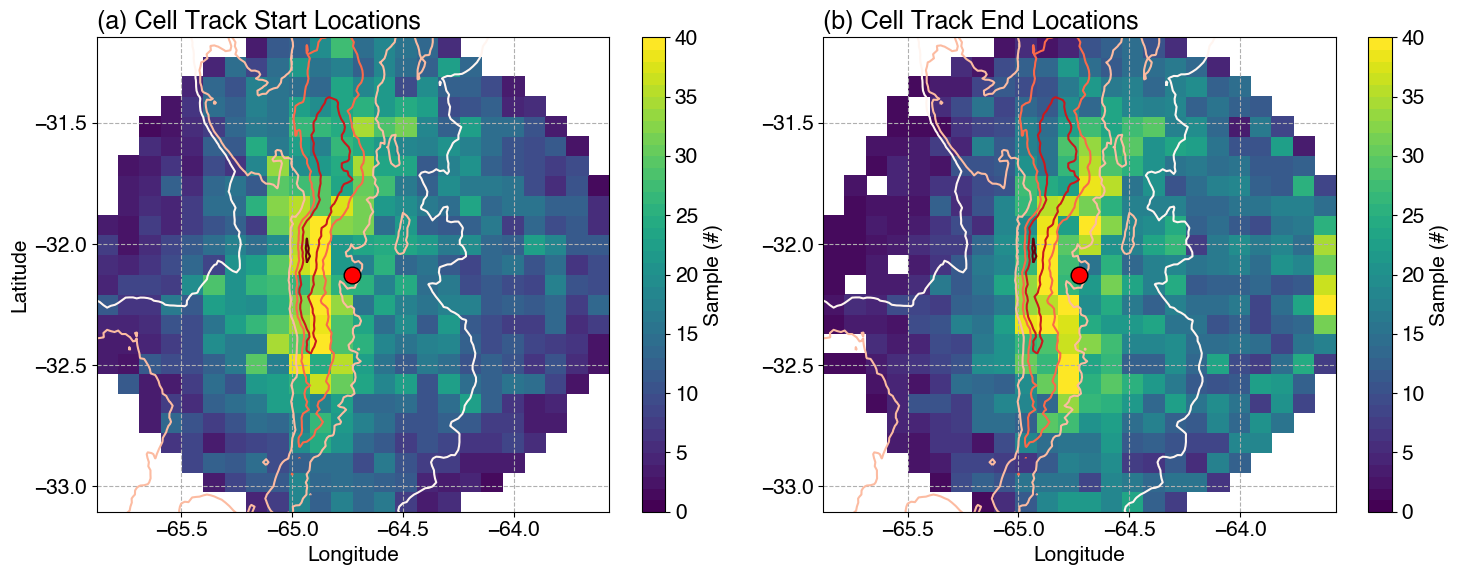

In [37]:
dataarr = [hist2d_startloc, hist2d_endloc]
levels = [np.arange(0, 41, 1), np.arange(0, 41, 1)]
cmap = ['viridis', 'viridis']
cmap_topo = 'Reds'
titles = ['(a) Cell Track Start Locations', '(b) Cell Track End Locations']
cblabels = ['Sample (#)', 'Sample (#)']
figname = f'{figdir}celltrack_startend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname)

In [38]:
np.nansum(hist2d_endloc_eSDC), np.nansum(hist2d_endloc_wSDC)

(4918.0, 1969.0)

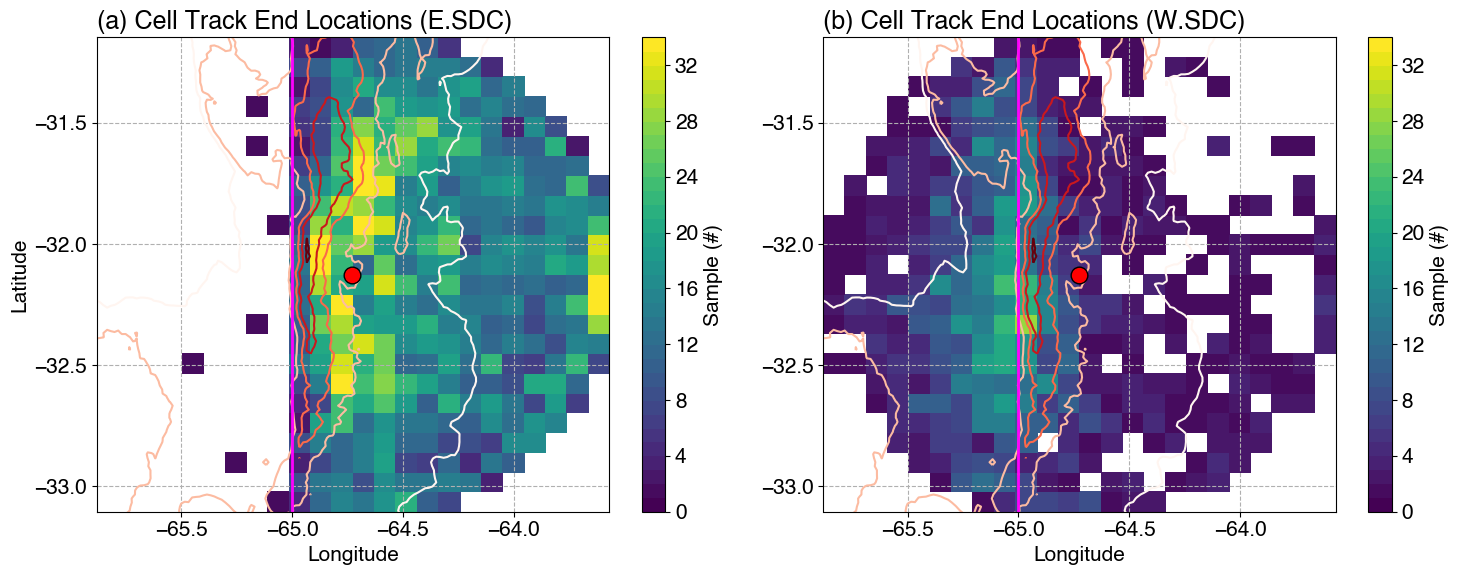

In [39]:
dataarr = [hist2d_endloc_eSDC, hist2d_endloc_wSDC]
levels = [np.arange(0, 34.1, 1), np.arange(0, 34.1, 1)]
cmap = ['viridis', 'viridis']
cmap_topo = 'Reds'
titles = ['(a) Cell Track End Locations (E.SDC)', '(b) Cell Track End Locations (W.SDC)']
cblabels = ['Sample (#)', 'Sample (#)']
figname = f'{figdir}celltrack_end_loc_eSDC_wSDC_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname, eSDC=lon_SDC)

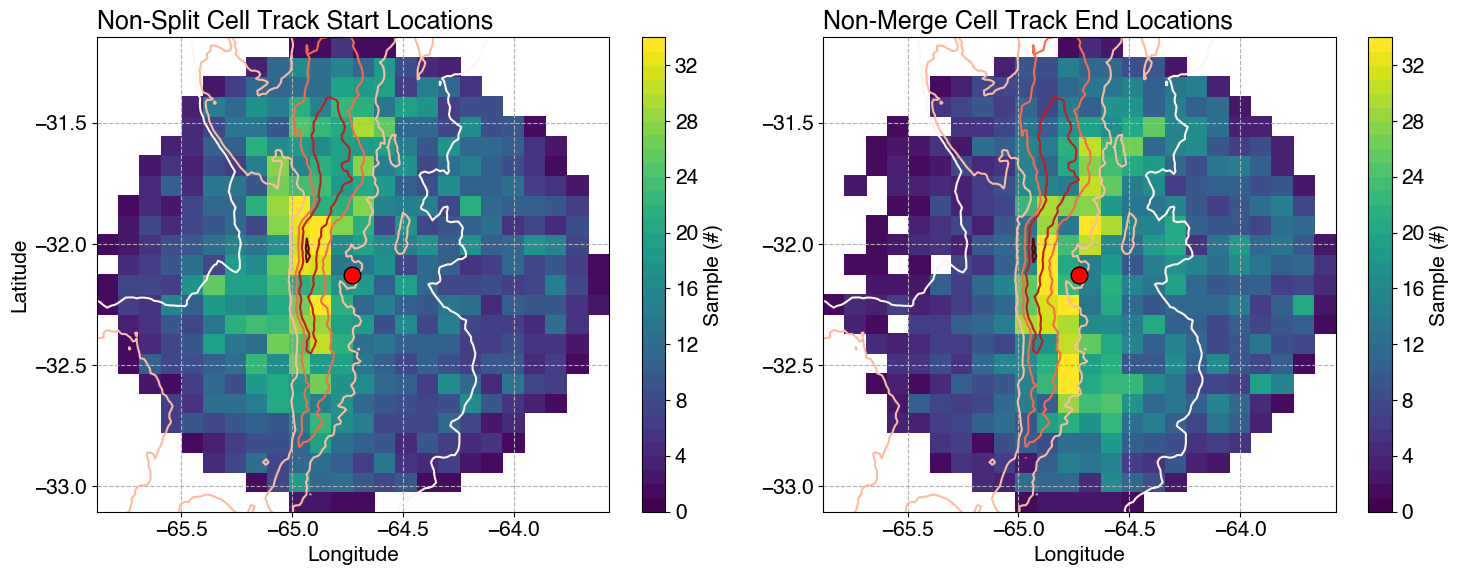

In [40]:
dataarr = [hist2d_startloc_nonsplit, hist2d_endloc_nonmerge]
levels = [np.arange(0, 34.1, 1), np.arange(0, 34.1, 1)]
cmap = ['viridis', 'viridis']
cmap_topo = 'Reds'
titles = ['Non-Split Cell Track Start Locations', 'Non-Merge Cell Track End Locations']
cblabels = ['Sample (#)', 'Sample (#)']
figname = f'{figdir}celltrack_nonsplitstart_nonmergeend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname)

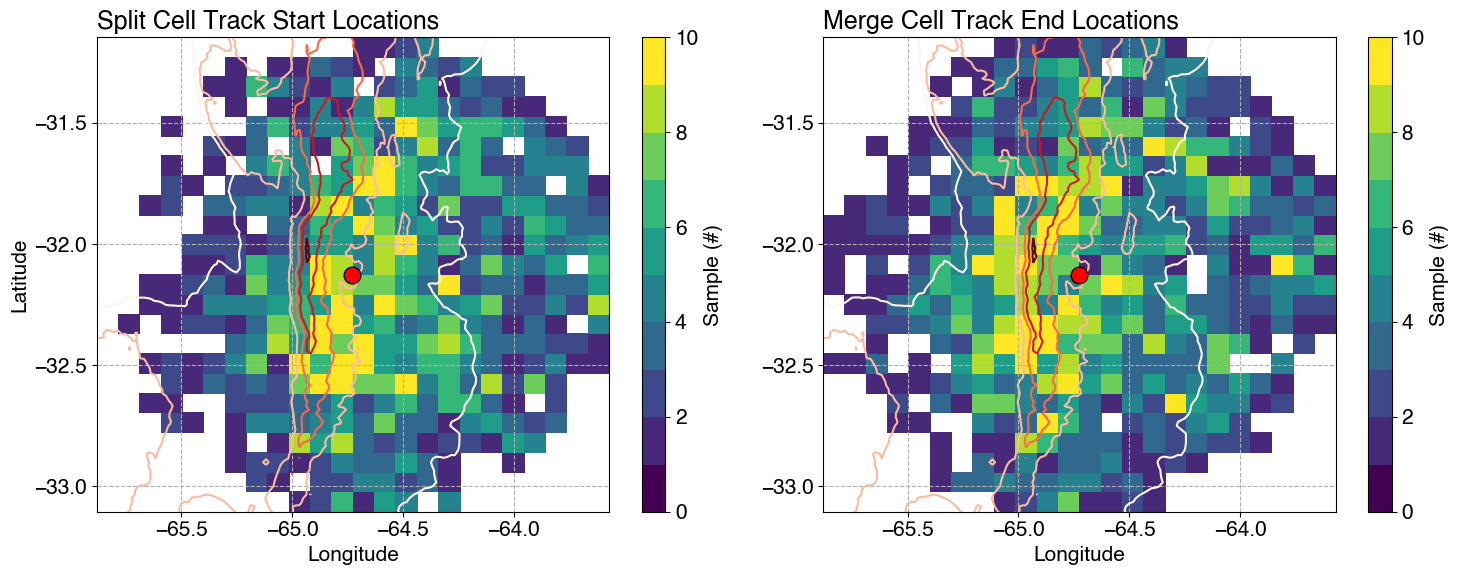

In [41]:
dataarr = [hist2d_startloc_split, hist2d_endloc_merge]
levels = [np.arange(0, 11, 1), np.arange(0, 11, 1)]
cmap = ['viridis','viridis']
cmap_topo = 'Reds'
titles = ['Split Cell Track Start Locations', 'Merge Cell Track End Locations']
cblabels = ['Sample (#)', 'Sample (#)']
figname = f'{figdir}celltrack_splitstart_mergeend_loc_0.1.png'
fig = plot_2heatmaps(dataarr, xbins, ybins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname)

In [42]:
shour_nonsplit = start_hour[nonsplit]
start_lon_nonsplit = start_lon.values[nonsplit]
start_lat_nonsplit = start_lat.values[nonsplit]

ehour_nonmerge = end_hour[nonmerge]
end_lon_nonmerge = end_lon[nonmerge]
end_lat_nonmerge = end_lat[nonmerge]

# Get track start hours [UTC]
mask0 = np.logical_and(shour_nonsplit >= 0, shour_nonsplit < 3)
mask3 = np.logical_and(shour_nonsplit >= 3, shour_nonsplit < 6)
mask6 = np.logical_and(shour_nonsplit >= 6, shour_nonsplit < 9)
mask9 = np.logical_and(shour_nonsplit >= 9, shour_nonsplit < 12)
mask12 = np.logical_and(shour_nonsplit >= 12, shour_nonsplit < 15)
mask15 = np.logical_and(shour_nonsplit >= 15, shour_nonsplit < 18)
mask18 = np.logical_and(shour_nonsplit >= 18, shour_nonsplit < 21)
mask21 = np.logical_and(shour_nonsplit >= 21, shour_nonsplit < 24)

# Get track start location by diurnal timing
bins = [12, 12]
ranges = [[minlat+buffer,maxlat-buffer], [minlon+buffer,maxlon-buffer]]
hist2d_startloc_nonsplit_hr0, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask0], start_lon_nonsplit[mask0], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr3, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask3], start_lon_nonsplit[mask3], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr6, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask6], start_lon_nonsplit[mask6], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr9, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask9], start_lon_nonsplit[mask9], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr12, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask12], start_lon_nonsplit[mask12], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr15, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask15], start_lon_nonsplit[mask15], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr18, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask18], start_lon_nonsplit[mask18], bins=bins, range=ranges)
hist2d_startloc_nonsplit_hr21, ybins_c, xbins_c  = np.histogram2d(start_lat_nonsplit[mask21], start_lon_nonsplit[mask21], bins=bins, range=ranges)

In [43]:
# Get track start hours [UTC]
mask0 = np.logical_and(start_hour >= 0, start_hour < 3)
mask3 = np.logical_and(start_hour >= 3, start_hour < 6)
mask6 = np.logical_and(start_hour >= 6, start_hour < 9)
mask9 = np.logical_and(start_hour >= 9, start_hour < 12)
mask12 = np.logical_and(start_hour >= 12, start_hour < 15)
mask15 = np.logical_and(start_hour >= 15, start_hour < 18)
mask18 = np.logical_and(start_hour >= 18, start_hour < 21)
mask21 = np.logical_and(start_hour >= 21, start_hour < 24)

# Get track start location by diurnal timing
bins = [12, 12]
ranges = [[minlat+buffer,maxlat-buffer], [minlon+buffer,maxlon-buffer]]
hist2d_startloc_hr0, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask0], start_lon.values[mask0], bins=bins, range=ranges)
hist2d_startloc_hr3, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask3], start_lon.values[mask3], bins=bins, range=ranges)
hist2d_startloc_hr6, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask6], start_lon.values[mask6], bins=bins, range=ranges)
hist2d_startloc_hr9, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask9], start_lon.values[mask9], bins=bins, range=ranges)
hist2d_startloc_hr12, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask12], start_lon.values[mask12], bins=bins, range=ranges)
hist2d_startloc_hr15, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask15], start_lon.values[mask15], bins=bins, range=ranges)
hist2d_startloc_hr18, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask18], start_lon.values[mask18], bins=bins, range=ranges)
hist2d_startloc_hr21, ybins_c, xbins_c = np.histogram2d(start_lat.values[mask21], start_lon.values[mask21], bins=bins, range=ranges)

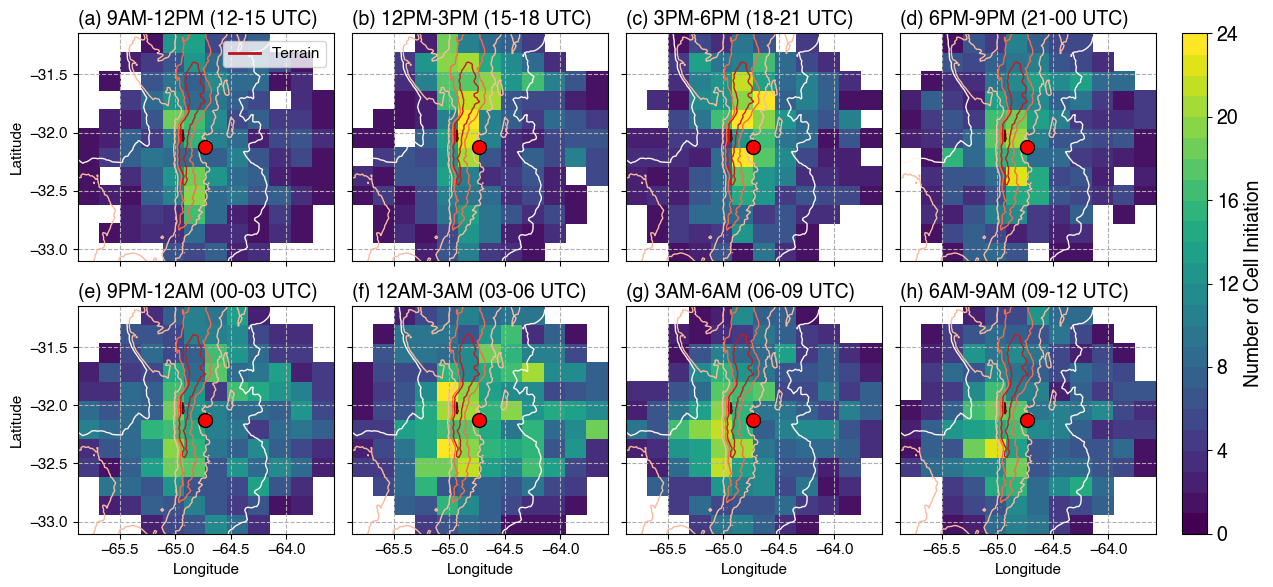

In [47]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Helvetica'
fig, axs = plt.subplots(2, 4, figsize=[14,6], dpi=100)
   
dataarr = [[hist2d_startloc_hr12, hist2d_startloc_hr15, hist2d_startloc_hr18, hist2d_startloc_hr21],
           [hist2d_startloc_hr0, hist2d_startloc_hr3, hist2d_startloc_hr6, hist2d_startloc_hr9]]
lonarr = xbins_c
latarr = ybins_c
levels = np.arange(0, 24.1, 1)
cbticks = np.arange(0, 24.1, 4)
titles = [['(a) 9AM-12PM (12-15 UTC)', '(b) 12PM-3PM (15-18 UTC)', '(c) 3PM-6PM (18-21 UTC)', '(d) 6PM-9PM (21-00 UTC)'],
          ['(e) 9PM-12AM (00-03 UTC)', '(f) 12AM-3AM (03-06 UTC)', '(g) 3AM-6AM (06-09 UTC)', '(h) 6AM-9AM (09-12 UTC)']]
cblabel = 'Number of Cell Initiation'

cmap = plt.get_cmap('viridis')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

xlabels = [['','','','',], ['Longitude','Longitude','Longitude','Longitude']]
ylabels = [['Latitude','','',''], ['Latitude','','','']]

marker_style = dict(color='k', linestyle='none', marker='o', markersize=10, markerfacecolor='red')
topo_levs = [500,1000,1500,2000,2500]
cmap_topo = 'Reds'

pcm_save = []

for row in range(2):
    for col in range(4):
        ax1 = axs[row, col]
        Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
        pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels[row][col])
        ax1.set_ylabel(ylabels[row][col])
        ax1.set_title(titles[row][col], loc='left', fontsize=14)
        ax1.set_xlim(np.min(lonarr), np.max(lonarr))
        ax1.set_ylim(np.min(latarr), np.max(latarr))
        ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
        ax1.set_yticks(np.arange(-33, maxlat, 0.5))
        ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1)
        ax1.plot(radar_lon, radar_lat, **marker_style)
        ax1.grid(ls='--')
        if (row == 0):
            ax1.xaxis.set_ticklabels([])
            if (col == 0):
                # Legend for terrain
                custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.8), lw=2)]
                ax1.legend(custom_lines, ['Terrain'], loc='upper right')
        if (col > 0):
            ax1.yaxis.set_ticklabels([])
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

# Adjust the layout before plotting colorbar
fig.tight_layout()

# Plot 1 color for the whole figure
cbar = fig.colorbar(pcm_save[0], ax=axs[:, :], shrink=1, pad=0.02)
cbar.set_ticks(cbticks)
cbar.set_label(label=cblabel, fontsize=14)
cbar.ax.tick_params(labelsize=14)
    
# # Plot 1 colorbar for each row
# for row in range(2):
#     cbar = fig.colorbar(pcm_save[row], ax=axs[row, :], shrink=1, pad=0.02, label=cblabel)
#     cbar.set_ticks(cbticks)

figname = f'{figdir}celltrack_start_loc_diurnal_cycle_0.2deg_2x4.png'
fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)

In [ ]:
mpl.rcParams['font.size'] = 11
mpl.rcParams['font.family'] = 'Helvetica'
fig, axs = plt.subplots(2, 4, figsize=[14,6], dpi=100)
   
dataarr = [[hist2d_startloc_nonsplit_hr12, hist2d_startloc_nonsplit_hr15, hist2d_startloc_nonsplit_hr18, hist2d_startloc_nonsplit_hr21],
           [hist2d_startloc_nonsplit_hr0, hist2d_startloc_nonsplit_hr3, hist2d_startloc_nonsplit_hr6, hist2d_startloc_nonsplit_hr9]]
lonarr = xbins_c
latarr = ybins_c
levels = np.arange(0, 20.1, 1)
cbticks = np.arange(0, 20.1, 2)
titles = [['(a) 9 AM - 12 PM', '(b) 12 PM - 3 PM', '(c) 3 PM - 6 PM', '(d) 6 PM - 9 PM'],
          ['(e) 9 PM - 12 AM', '(f) 12 AM - 3 AM', '(g) 3 AM - 6 AM', '(h) 6 AM - 9 AM']]
cblabel = 'Number of Track Initiation'

cmap = plt.get_cmap('viridis')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

xlabels = [['','','','',], ['Longitude','Longitude','Longitude','Longitude']]
ylabels = [['Latitude','','',''], ['Latitude','','','']]

marker_style = dict(color='k', linestyle='none', marker='o', markersize=10, markerfacecolor='red')
topo_levs = [500,1000,1500,2000,2500]
cmap_topo = 'Reds'

pcm_save = []

for row in range(2):
    for col in range(4):
        ax1 = axs[row, col]
        Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
        pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels[row][col])
        ax1.set_ylabel(ylabels[row][col])
        ax1.set_title(titles[row][col], loc='left', fontsize=14)
        ax1.set_xlim(np.min(lonarr), np.max(lonarr))
        ax1.set_ylim(np.min(latarr), np.max(latarr))
        ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
        ax1.set_yticks(np.arange(-33, maxlat, 0.5))
        ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=1)
        ax1.plot(radar_lon, radar_lat, **marker_style)
        ax1.grid(ls='--')
        if (row == 0):
            ax1.xaxis.set_ticklabels([])
            if (col == 0):
                # Legend for terrain
                custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.8), lw=2)]
                ax1.legend(custom_lines, ['Terrain'], loc='upper right')
        if (col > 0):
            ax1.yaxis.set_ticklabels([])
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

# Adjust the layout before plotting colorbar
fig.tight_layout()

# Plot 1 color for the whole figure
cbar = fig.colorbar(pcm_save[0], ax=axs[:, :], shrink=1, pad=0.02)
cbar.set_ticks(cbticks)
cbar.set_label(label=cblabel, fontsize=14)
cbar.ax.tick_params(labelsize=14)

# # Plot 1 colorbar for each row
# for row in range(2):
#     cbar = fig.colorbar(pcm_save[row], ax=axs[row, :], shrink=1, pad=0.02, label=cblabel)
#     cbar.set_ticks(cbticks)

fig.savefig(f'{figdir}celltrack_nonsplitstart_loc_diurnal_cycle_0.2deg_2x4.png', bbox_inches='tight', dpi=300)

In [52]:
figname

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/celltrack_start_loc_diurnal_cycle_0.2deg_2x4.png'

In [46]:
xbins_c, ybins_c

(array([-65.87886047, -65.68637435, -65.49388822, -65.30140209,
        -65.10891596, -64.91642984, -64.72394371, -64.53145758,
        -64.33897146, -64.14648533, -63.9539992 , -63.76151307,
        -63.56902695]),
 array([-33.10429382, -32.94115496, -32.77801609, -32.61487722,
        -32.45173836, -32.28859949, -32.12546062, -31.96232176,
        -31.79918289, -31.63604403, -31.47290516, -31.30976629,
        -31.14662743]))

In [47]:
xbins, ybins

(array([-65.87886047, -65.78261741, -65.68637435, -65.59013128,
        -65.49388822, -65.39764516, -65.30140209, -65.20515903,
        -65.10891596, -65.0126729 , -64.91642984, -64.82018677,
        -64.72394371, -64.62770065, -64.53145758, -64.43521452,
        -64.33897146, -64.24272839, -64.14648533, -64.05024227,
        -63.9539992 , -63.85775614, -63.76151307, -63.66527001,
        -63.56902695]),
 array([-33.10429382, -33.02272439, -32.94115496, -32.85958552,
        -32.77801609, -32.69644666, -32.61487722, -32.53330779,
        -32.45173836, -32.37016892, -32.28859949, -32.20703006,
        -32.12546062, -32.04389119, -31.96232176, -31.88075233,
        -31.79918289, -31.71761346, -31.63604403, -31.55447459,
        -31.47290516, -31.39133573, -31.30976629, -31.22819686,
        -31.14662743]))

In [79]:
#heatmaps (variable (e.g., cell area, lifetime) value in lon-lat bins)
# lonbinsize = 0.2
# latbinsize = 0.2
# lon_nbin = 13
# lat_nbin = 12
# lonbinsize = 0.15
# latbinsize = 0.14
# lon_nbin = 17
# lat_nbin = 16
lonbinsize = 0.14
latbinsize = 0.13
lon_nbin = 18
lat_nbin = 17

lonbins = np.arange(lon_nbin)*lonbinsize + minlon
latbins = np.arange(lat_nbin)*latbinsize + minlat - 0.05

Mean_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_Area_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH10_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH20_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
pt95_ETH30_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH40_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Median_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_ETH50_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Samples_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Mean_CTT_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Min_CTT_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Mean_CTH_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)
Max_CTH_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

Lon_flat = np.array(cell_lon).flatten()
Lat_flat = np.array(cell_lat).flatten()
Area_flat = np.array(cell_area).flatten()
ETH10_flat = np.array(eth10).flatten()
ETH20_flat = np.array(eth20).flatten()
ETH30_flat = np.array(eth30).flatten()
ETH40_flat = np.array(eth40).flatten()
ETH50_flat = np.array(eth50).flatten()
CTT_flat = np.array(ctt).flatten()
CTH_flat = np.array(cth).flatten()

ETH30_gt7km_flat = np.array(eth30.where(eth30 > 7)).flatten()
Mean_ETH30_7km_heatmap = np.full((lat_nbin, lon_nbin), np.nan, dtype=float)

min_nsample = 10

# Loop over each lat/lon bin
for i in np.arange(lon_nbin):
    for j in np.arange(lat_nbin):
        # Find all cells within the bin and have cell area > 0
        mask = np.logical_and(np.logical_and(np.logical_and(np.logical_and(Lon_flat >= lonbins[i], Lon_flat < lonbins[i]+lonbinsize),
                              Lat_flat >= latbins[j]), Lat_flat < latbins[j]+latbinsize), Area_flat > 0)
        # Record number of samples in the bin
        Samples_heatmap[j,i] = np.size(np.where(mask == True))
        # Compute statistics if number of samples > threshold
        if np.size(np.where(mask == True)) >= min_nsample:
            Mean_Area_heatmap[j,i] = np.nanmean(Area_flat[mask])
            Median_Area_heatmap[j,i] = np.nanmedian(Area_flat[mask])
            Max_Area_heatmap[j,i] = np.nanmax(Area_flat[mask])
            Mean_ETH10_heatmap[j,i] = np.nanmean(ETH10_flat[mask])
            Median_ETH10_heatmap[j,i] = np.nanmedian(ETH10_flat[mask])
            Max_ETH10_heatmap[j,i] = np.nanmax(ETH10_flat[mask])
            Mean_ETH20_heatmap[j,i] = np.nanmean(ETH20_flat[mask])
            Median_ETH20_heatmap[j,i] = np.nanmedian(ETH20_flat[mask])
            Max_ETH20_heatmap[j,i] = np.nanmax(ETH20_flat[mask])
            Mean_ETH30_heatmap[j,i] = np.nanmean(ETH30_flat[mask])
            Median_ETH30_heatmap[j,i] = np.nanmedian(ETH30_flat[mask])
            Max_ETH30_heatmap[j,i] = np.nanmax(ETH30_flat[mask])
            pt95_ETH30_heatmap[j,i] = np.nanpercentile(ETH30_flat[mask], 95)
            Mean_ETH30_7km_heatmap[j,i] = np.nanmean(ETH30_gt7km_flat[mask])
            
            Mean_ETH40_heatmap[j,i] = np.nanmean(ETH40_flat[mask])
            Median_ETH40_heatmap[j,i] = np.nanmedian(ETH40_flat[mask])
            Max_ETH40_heatmap[j,i] = np.nanmax(ETH40_flat[mask])
            Mean_ETH50_heatmap[j,i] = np.nanmean(ETH50_flat[mask])
            Median_ETH50_heatmap[j,i] = np.nanmedian(ETH50_flat[mask])
            Max_ETH50_heatmap[j,i] = np.nanmax(ETH50_flat[mask])
            
            Mean_CTT_heatmap[j,i] = np.nanmean(CTT_flat[mask])
            Min_CTT_heatmap[j,i] = np.nanmin(CTT_flat[mask])
            Mean_CTH_heatmap[j,i] = np.nanmean(CTH_flat[mask])
            Max_CTH_heatmap[j,i] = np.nanmax(CTH_flat[mask])

<ipython-input-83-2e02a959c7f8>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lonbins, latbins, pt95_ETH30_heatmap, cmap='plasma')


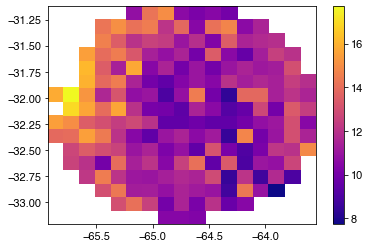

In [83]:
plt.pcolormesh(lonbins, latbins, pt95_ETH30_heatmap, cmap='plasma')
plt.colorbar()

<ipython-input-78-331d8e605d54>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lonbins, latbins, Min_CTT_heatmap, vmin=178, vmax=200, cmap='plasma_r')


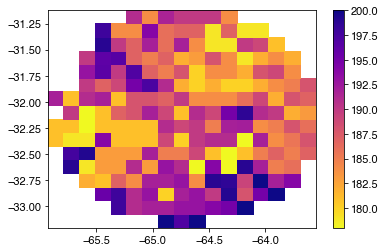

In [78]:
plt.pcolormesh(lonbins, latbins, Min_CTT_heatmap, vmin=178, vmax=200, cmap='plasma_r')
plt.colorbar()

<ipython-input-87-a210871b6c17>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lonbins, latbins, Max_CTH_heatmap, vmin=15, vmax=19, cmap='plasma')


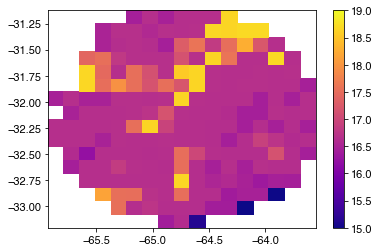

In [87]:
plt.pcolormesh(lonbins, latbins, Max_CTH_heatmap, vmin=15, vmax=19, cmap='plasma')
plt.colorbar()

<ipython-input-63-e7e59044a93c>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lonbins, latbins, Mean_CTT_heatmap, vmin=205, vmax=240, cmap='plasma_r')


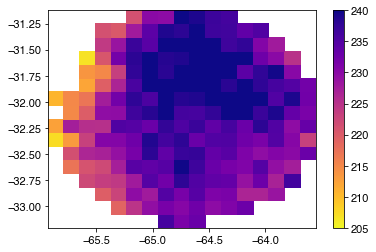

In [63]:
plt.pcolormesh(lonbins, latbins, Mean_CTT_heatmap, vmin=205, vmax=240, cmap='plasma_r')
plt.colorbar()

In [67]:
hist2d_startloc_02deg, yy, xx = np.histogram2d(start_lat, start_lon, bins=[latbins, lonbins])
hist2d_endloc_02deg, yy, xx = np.histogram2d(end_lat, end_lon, bins=[latbins, lonbins])

In [80]:
# plt.pcolormesh(lonbins, latbins, hist2d_startloc_02deg, vmax=90)
# plt.colorbar()

In [81]:
# plt.pcolormesh(lonbins, latbins, hist2d_endloc_02deg, vmax=90)
# plt.colorbar()

In [97]:
def plot_4heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname, eSDC=None):
    mpl.rcParams['font.size'] = 13
    mpl.rcParams['font.family'] = 'Helvetica'
    fig, axes = plt.subplots(2, 2, figsize=(12.5,10), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500,1000,1500,2000,2500]

    for row in range(2):
        for col in range(2):
            ax = axes[row,col]
            Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
            cmap = plt.get_cmap(cmaps[row][col])
            norm = mpl.colors.BoundaryNorm(boundaries=levels[row][col], ncolors=cmap.N)
            p1 = ax.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
            cb = plt.colorbar(p1, ax=ax, label=cblabels[row][col], ticks=cbticks[row][col])
            ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlim(np.min(lonarr), np.max(lonarr))
            ax.set_ylim(np.min(latarr), np.max(latarr))
            ax.set_xticks(np.arange(-65.5, maxlon, 0.5))
            ax.set_yticks(np.arange(-33, maxlat, 0.5))
            ax.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo[row][col], linewidths=1.5)
            ax.plot(radar_lon, radar_lat, **marker_style)
            ax.grid(ls='--')
            if eSDC is not None:
                ax.axvline(x=eSDC, color='magenta', lw=2)

            # Legend for terrain
            custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo[row][col])(0.8), lw=2)]
            ax.legend(custom_lines, ['Terrain'], loc='upper right')

    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', facecolor='w', dpi=300)
    
    return fig

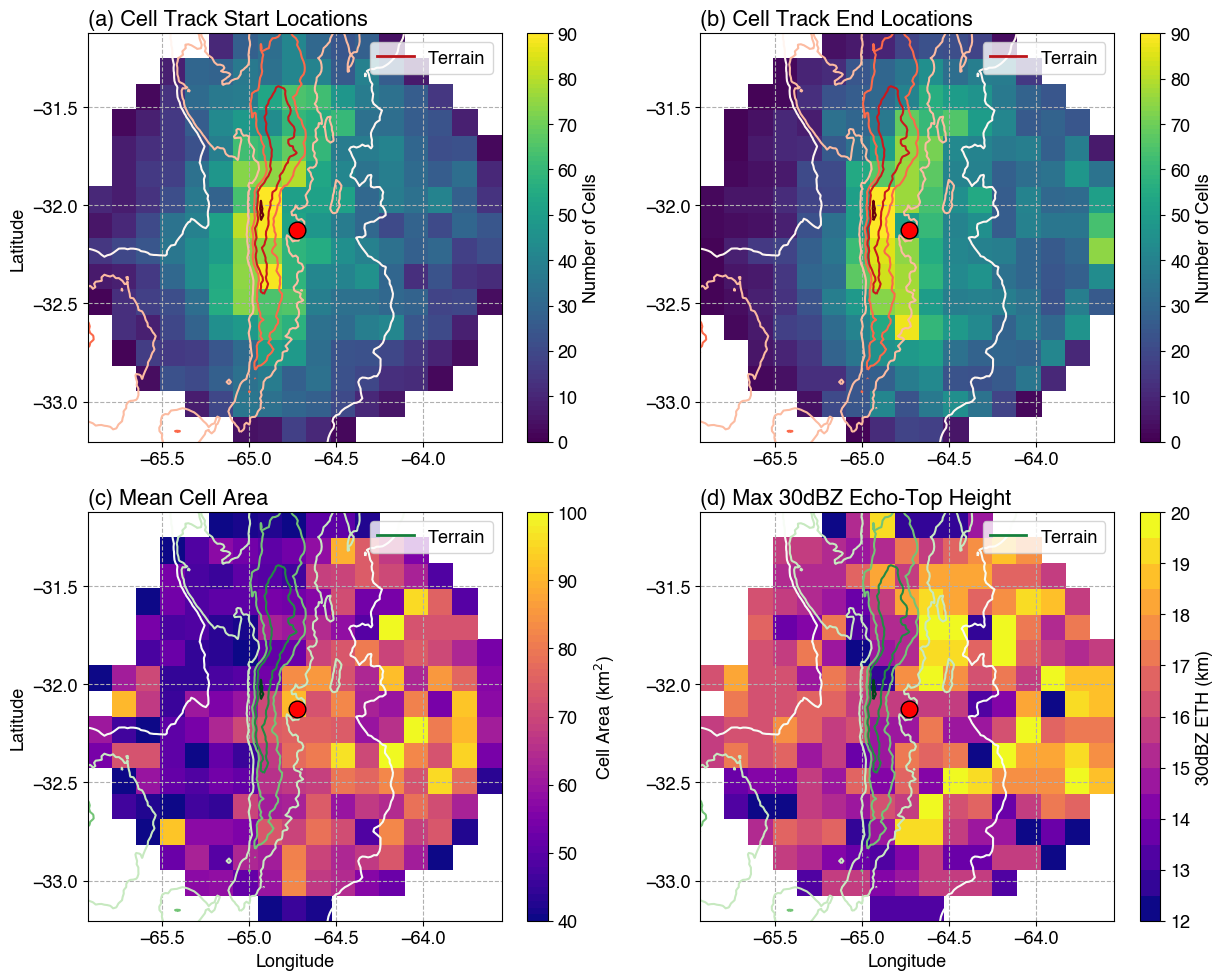

In [99]:
dataarr = [[hist2d_startloc_02deg, hist2d_endloc_02deg], [Mean_Area_heatmap, Max_ETH30_heatmap]]
levels = [[np.arange(0, 90.1, 1), np.arange(0, 90.1, 1)], [np.arange(40, 100.1, 1), np.arange(12, 20.1, 0.5)]]
cbticks = [[np.arange(0, 90.1, 10), np.arange(0, 90.1, 10)], [np.arange(40, 100.1, 10), np.arange(12, 20.1, 1)]]
cmap = [['viridis', 'viridis'], ['plasma','plasma']]
cmap_topo = [['Reds', 'Reds'], ['Greens', 'Greens']]
titles = [['(a) Cell Track Start Locations', '(b) Cell Track End Locations'], 
          ['(c) Mean Cell Area', '(d) Max 30dBZ Echo-Top Height'],]
cblabels = [['Number of Cells', 'Number of Cells'], ['Cell Area (km$^2$)', '30dBZ ETH (km)']]
xlabels = [['',''], ['Longitude','Longitude']]
ylabels = [['Latitude',''],['Latitude','']]
figname = f'{figdir}celltrack_StartEndloc_MeanCellArea_Max30dBZETH_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, cbticks, titles, xlabels, ylabels, figname)

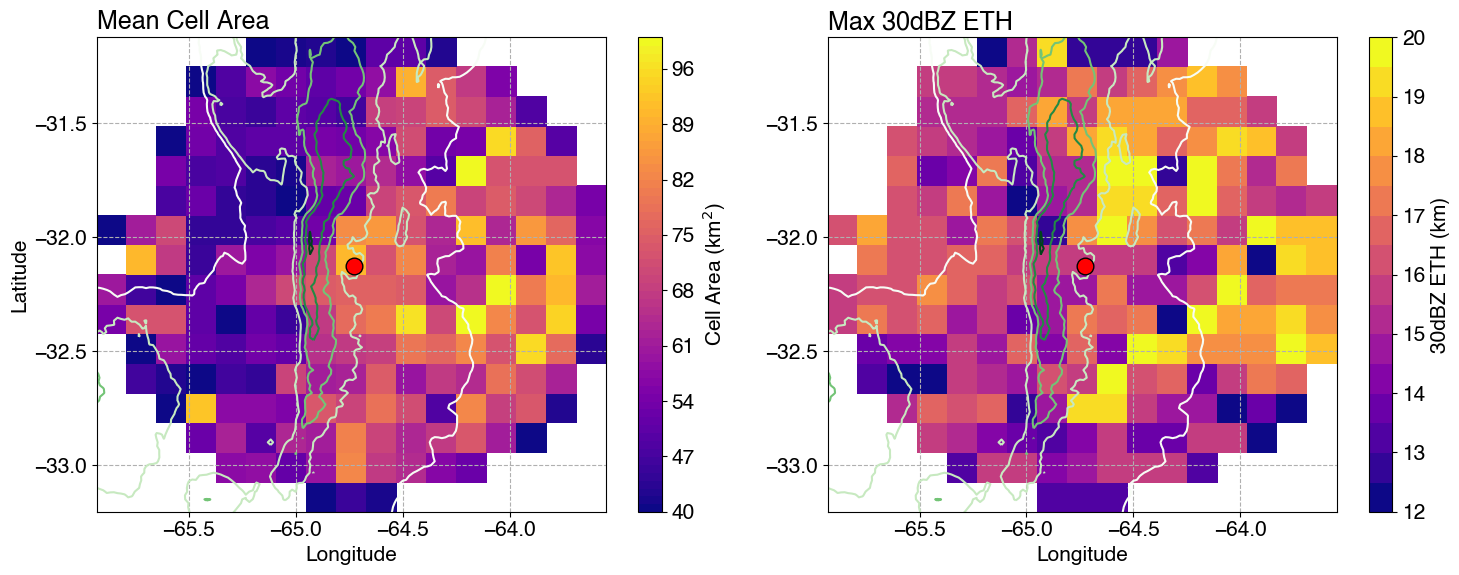

In [71]:
dataarr = [Mean_Area_heatmap, Max_ETH30_heatmap]
# levels = [np.arange(40, 91, 1), np.arange(12, 21.1, 0.5)]
levels = [np.arange(40, 100.1, 1), np.arange(12, 20.1, 0.5)]
# dataarr = [Mean_Area_heatmap, Mean_ETH30_7km_heatmap]
# levels = [np.arange(40, 91, 1), np.arange(7, 12.1, 0.5)]
cmap = ['plasma','plasma']
cmap_topo = 'Greens'
titles = ['Mean Cell Area', 'Max 30dBZ ETH']
cblabels = ['Cell Area (km$^2$)', '30dBZ ETH (km)']
figname = f'{figdir}MeanCellArea_Max30dBZETH_0.2deg.png'
fig = plot_2heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmap, cmap_topo, cblabels, titles, figname)

In [99]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'

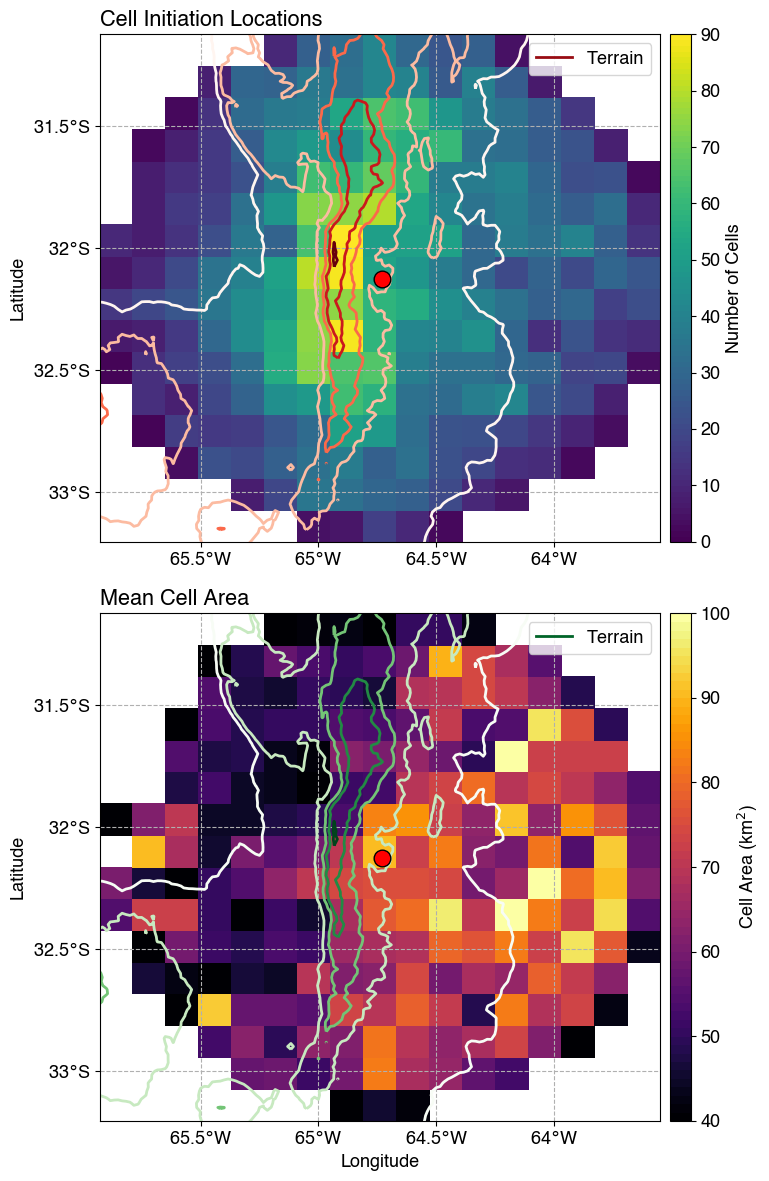

In [98]:
mpl.rcParams['font.size'] = 13
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(2, 1, figsize=(8,12), dpi=100)
marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
topo_levs = [500,1000,1500,2000,2500]

# xlims = [np.min(lonarr)+0.05, np.max(lonarr)-0.05]
# ylims = [np.min(latarr)+0.05, np.max(latarr)-0.05]
# xlims = [np.min(lonarr), np.max(lonarr)]
# ylims = [np.min(latarr), np.max(latarr)]
xlims = [np.min(lonbins), np.max(lonbins)]
ylims = [np.min(latbins), np.max(latbins)]
xticklabels = [r'65.5$\degree$W',r'65$\degree$W',r'64.5$\degree$W',r'64$\degree$W',]
yticklabels = [r'33$\degree$S',r'32.5$\degree$S',r'32$\degree$S',r'31.5$\degree$S']

cmap_topo = 'Reds'
cmap = plt.get_cmap('viridis')
levels = np.arange(0, 90.1, 1)
cbticks = np.arange(0, 90.1, 10)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

ax1 = axes[0]
# Zm = np.ma.masked_where(hist2d_startloc == 0, hist2d_startloc)
# p1 = ax1.pcolormesh(xbins, ybins, Zm, norm=norm, cmap=cmap)
Zm = np.ma.masked_where(hist2d_startloc_02deg == 0, hist2d_startloc_02deg)
p1 = ax1.pcolormesh(lonbins, latbins, Zm, norm=norm, cmap=cmap)
cb = plt.colorbar(p1, ax=ax1, label='Number of Cells', ticks=cbticks, pad=0.015, aspect=25)
# ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Cell Initiation Locations', loc='left')
ax1.set_xlim(xlims[0], xlims[1])
ax1.set_ylim(ylims[0], ylims[1])
ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
ax1.set_yticks(np.arange(-33, maxlat, 0.5))
ax1.set_xticklabels(xticklabels)
ax1.set_yticklabels(yticklabels)
ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=2)
ax1.plot(radar_lon, radar_lat, **marker_style)
ax1.grid(ls='--')
# Legend for terrain
custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.9), lw=2)]
ax1.legend(custom_lines, ['Terrain'], loc='upper right')


cmap_topo = 'Greens'
cmap = plt.get_cmap('inferno')
levels = np.arange(40, 100.1, 1)
cbticks = np.arange(40, 100.1, 10)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

ax2 = axes[1]
Zm = np.ma.masked_where((Mean_Area_heatmap == 0) | (Samples_heatmap < 10), Mean_Area_heatmap)
p2 = ax2.pcolormesh(lonbins, latbins, Zm, norm=norm, cmap=cmap)
cb = plt.colorbar(p2, ax=ax2, label='Cell Area (km$^{2}$)', ticks=cbticks, pad=0.015, aspect=25)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Mean Cell Area', loc='left')
ax2.set_xlim(xlims[0], xlims[1])
ax2.set_ylim(ylims[0], ylims[1])
ax2.set_xticks(np.arange(-65.5, maxlon, 0.5))
ax2.set_yticks(np.arange(-33, maxlat, 0.5))
ax2.set_xticklabels(xticklabels)
ax2.set_yticklabels(yticklabels)
ax2.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo, linewidths=2)
ax2.plot(radar_lon, radar_lat, **marker_style)
ax2.grid(ls='--')
# Legend for terrain
custom_lines = [mpl.lines.Line2D([0], [0], color=plt.get_cmap(cmap_topo)(0.9), lw=2)]
ax2.legend(custom_lines, ['Terrain'], loc='upper right')

fig.tight_layout()
canvas = FigureCanvas(fig)
figname = f'{figdir}celltrack_startloc_meanarea_4BAMS.png'
canvas.print_png(figname)
# fig.savefig(figname)
fig.savefig(f'{figdir}celltrack_startloc_meanarea_4BAMS.png', bbox_inches='tight', dpi=300)

In [43]:
def plot_4heatmaps(dataarr, lonarr, latarr, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    
    fig, axes = plt.subplots(2, 2, figsize=(10,8), dpi=100)
    marker_style = dict(color='k', linestyle='none', marker='o', markersize=12, markerfacecolor='red')
    topo_levs = [500,1000,1500,2000,2500]
    
    xlabels = [['Longitude','Longitude',], ['Longitude','Longitude']]
    ylabels = [['Latitude','Latitude',], ['Latitude','Latitude',]]

    for row in range(2):
        for col in range(2):
            ax1 = axes[row, col]
            cmap = plt.get_cmap(cmaps[row][col])
            norm = mpl.colors.BoundaryNorm(boundaries=levels[row][col], ncolors=cmap.N)
            Zm = np.ma.masked_where(dataarr[row][col] == 0, dataarr[row][col])
            pcm = ax1.pcolormesh(lonarr, latarr, Zm, norm=norm, cmap=cmap)
            cb = plt.colorbar(pcm, ax=ax1, label=cblabels[row][col])
            cb.set_ticks(cbticks[row][col])
            ax1.set_xlim(np.min(lonarr), np.max(lonarr))
            ax1.set_ylim(np.min(latarr), np.max(latarr))
            ax1.set_xlabel(xlabels[row][col])
            ax1.set_ylabel(ylabels[row][col])
            ax1.set_title(titles[row][col], loc='left', fontsize=16)
            ax1.set_xticks(np.arange(-65.5, maxlon, 0.5))
            ax1.set_yticks(np.arange(-33, maxlat, 0.5))
            ax1.contour(topoLon, topoLat, topoZ, levels=topo_levs, cmap=cmap_topo[row][col], linewidths=1.5)
            ax1.plot(radar_lon, radar_lat, **marker_style)
            ax1.grid(ls='--')
#             if (row == 0):
#                 ax1.xaxis.set_ticklabels([])
#             if (col > 0):
#                 ax1.yaxis.set_ticklabels([])

    fig.tight_layout()
    fig.savefig(figname, bbox_inches='tight', dpi=300)
    
    return fig

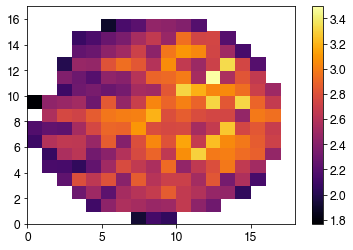

In [106]:
plt.pcolormesh(np.log10(Max_Area_heatmap), cmap='inferno')
plt.colorbar()

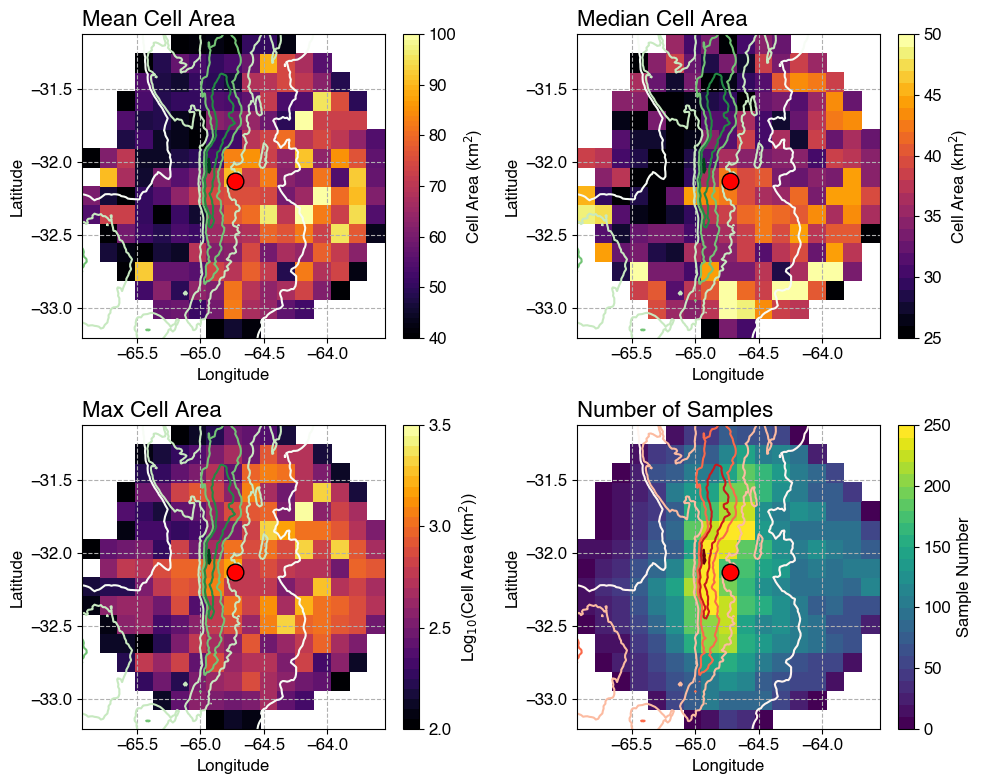

In [112]:
dataarr = [[Mean_Area_heatmap, Median_Area_heatmap],
           [np.log10(Max_Area_heatmap), Samples_heatmap]]
# levels = [[np.arange(40, 90.1, 1), np.arange(25, 50.1, 1)], 
#           [np.arange(250, 2501, 50), np.arange(0, 500.1, 10)]]
# cbticks = [[np.arange(40, 90.1, 5), np.arange(25, 50.1, 5)], 
#            [np.arange(250, 2500.1, 250), np.arange(0, 500.1, 50)]]
levels = [[np.arange(40, 100.1, 1), np.arange(25, 50.1, 1)], 
          [np.arange(2.0, 3.51, 0.05), np.arange(0, 250.1, 10)]]
cbticks = [[np.arange(40, 100.1, 10), np.arange(25, 50.1, 5)], 
           [np.arange(2.0, 3.51, 0.5), np.arange(0, 250.1, 50)]]
# cmaps = [['plasma', 'plasma'], 
#          ['plasma', 'viridis']]
cmaps = [['inferno', 'inferno'], 
         ['inferno', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell Area', 'Median Cell Area'],
          ['Max Cell Area', 'Number of Samples']]
cblabels = [['Cell Area (km$^{2}$)', 'Cell Area (km$^{2}$)'],
            ['Log$_{10}$(Cell Area (km$^{2}$))', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_area_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

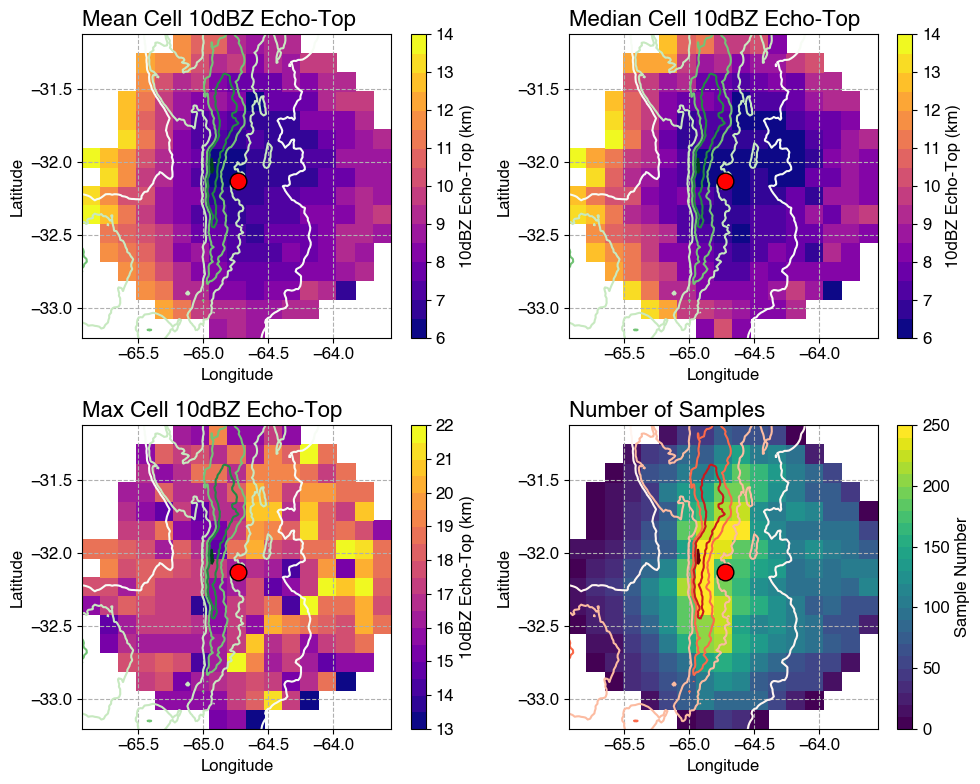

In [113]:
dataarr = [[Mean_ETH10_heatmap, Median_ETH10_heatmap],
           [Max_ETH10_heatmap, Samples_heatmap]]
# levels = [[np.arange(6, 14.1, 0.5), np.arange(6, 14.1, 0.5)], 
#           [np.arange(13, 22.1, 0.5), np.arange(0, 500.1, 10)]]
# cbticks = [[np.arange(6, 14.1, 1), np.arange(6, 14.1, 1)], 
#           [np.arange(13, 22.1, 1), np.arange(0, 500.1, 50)]]
levels = [[np.arange(6, 14.1, 0.5), np.arange(6, 14.1, 0.5)], 
          [np.arange(13, 22.1, 0.5), np.arange(0, 250.1, 10)]]
cbticks = [[np.arange(6, 14.1, 1), np.arange(6, 14.1, 1)], 
          [np.arange(13, 22.1, 1), np.arange(0, 250.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 10dBZ Echo-Top', 'Median Cell 10dBZ Echo-Top'],
          ['Max Cell 10dBZ Echo-Top', 'Number of Samples']]
cblabels = [['10dBZ Echo-Top (km)', '10dBZ Echo-Top (km)'],
            ['10dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_10dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

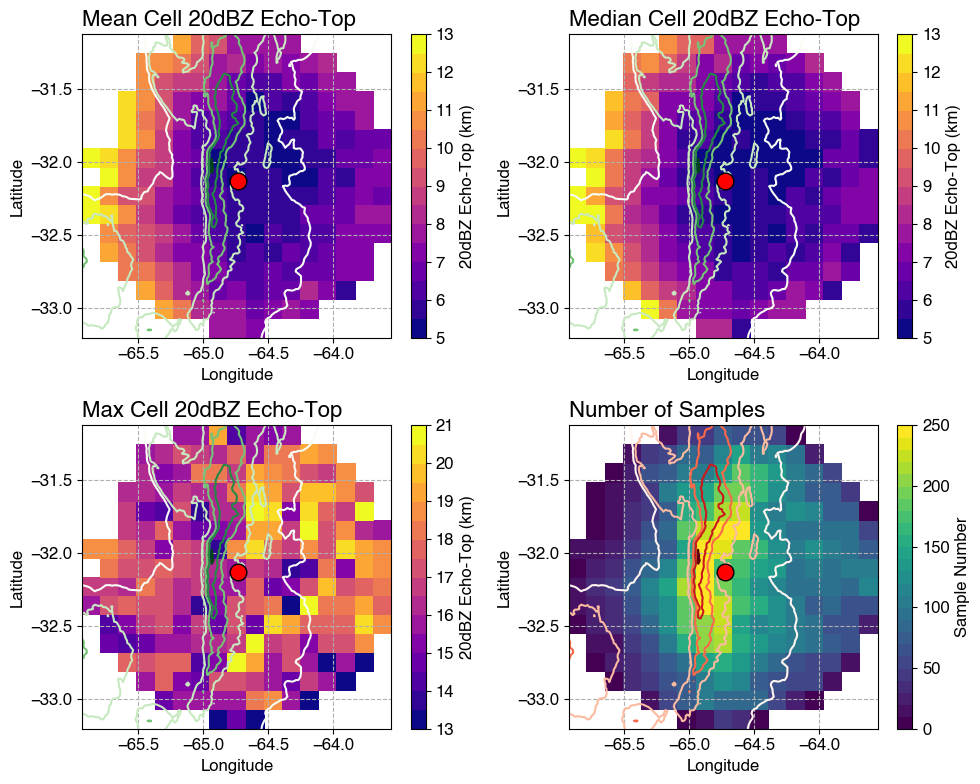

In [117]:
dataarr = [[Mean_ETH20_heatmap, Median_ETH20_heatmap],
           [Max_ETH20_heatmap, Samples_heatmap]]
# levels = [[np.arange(5, 13.1, 0.5), np.arange(5, 13.1, 0.5)], 
#           [np.arange(13, 21.1, 0.5), np.arange(0, 500.1, 10)]]
# cbticks = [[np.arange(5, 13.1, 1), np.arange(5, 13.1, 1)], 
#           [np.arange(13, 21.1, 1), np.arange(0, 500.1, 50)]]
levels = [[np.arange(5, 13.1, 0.5), np.arange(5, 13.1, 0.5)], 
          [np.arange(13, 21.1, 0.5), np.arange(0, 250.1, 10)]]
cbticks = [[np.arange(5, 13.1, 1), np.arange(5, 13.1, 1)], 
          [np.arange(13, 21.1, 1), np.arange(0, 250.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 20dBZ Echo-Top', 'Median Cell 20dBZ Echo-Top'],
          ['Max Cell 20dBZ Echo-Top', 'Number of Samples']]
cblabels = [['20dBZ Echo-Top (km)', '20dBZ Echo-Top (km)'],
            ['20dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_20dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

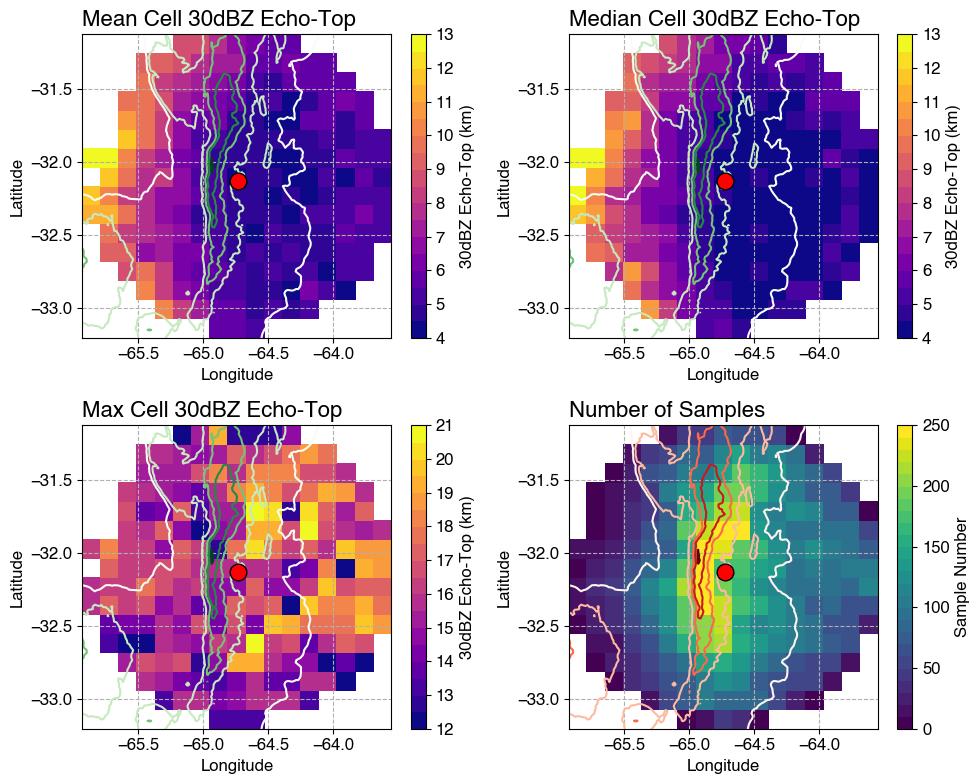

In [119]:
dataarr = [[Mean_ETH30_heatmap, Median_ETH30_heatmap],
           [Max_ETH30_heatmap, Samples_heatmap]]
# levels = [[np.arange(4, 13.1, 0.5), np.arange(4, 13.1, 0.5)], 
#           [np.arange(12, 21.01, 0.5), np.arange(0, 500.1, 10)]]
# cbticks = [[np.arange(4, 13.1, 1), np.arange(4, 13.1, 1)], 
#           [np.arange(12, 21.1, 1), np.arange(0, 500.1, 50)]]
levels = [[np.arange(4, 13.1, 0.5), np.arange(4, 13.1, 0.5)], 
          [np.arange(12, 21.1, 0.5), np.arange(0, 250.1, 10)]]
cbticks = [[np.arange(4, 13.1, 1), np.arange(4, 13.1, 1)], 
          [np.arange(12, 21.1, 1), np.arange(0, 250.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 30dBZ Echo-Top', 'Median Cell 30dBZ Echo-Top'],
          ['Max Cell 30dBZ Echo-Top', 'Number of Samples']]
cblabels = [['30dBZ Echo-Top (km)', '30dBZ Echo-Top (km)'],
            ['30dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_30dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

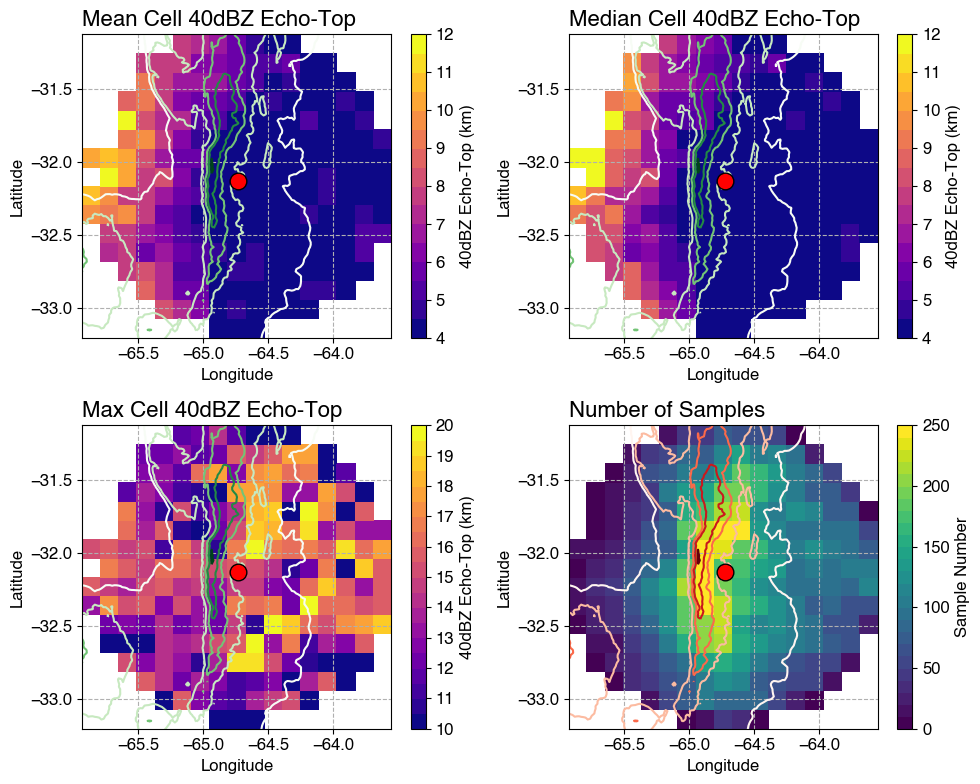

In [120]:
dataarr = [[Mean_ETH40_heatmap, Median_ETH40_heatmap],
           [Max_ETH40_heatmap, Samples_heatmap]]
# levels = [[np.arange(4, 12.1, 0.5), np.arange(4, 12.1, 0.5)], 
#           [np.arange(10, 20.01, 0.5), np.arange(0, 500.1, 10)]]
# cbticks = [[np.arange(4, 12.1, 1), np.arange(4, 12.1, 1)], 
#           [np.arange(10, 20.1, 1), np.arange(0, 500.1, 50)]]
levels = [[np.arange(4, 12.1, 0.5), np.arange(4, 12.1, 0.5)], 
          [np.arange(10, 20.1, 0.5), np.arange(0, 250.1, 10)]]
cbticks = [[np.arange(4, 12.1, 1), np.arange(4, 12.1, 1)], 
          [np.arange(10, 20.1, 1), np.arange(0, 250.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 40dBZ Echo-Top', 'Median Cell 40dBZ Echo-Top'],
          ['Max Cell 40dBZ Echo-Top', 'Number of Samples']]
cblabels = [['40dBZ Echo-Top (km)', '40dBZ Echo-Top (km)'],
            ['40dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_40dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

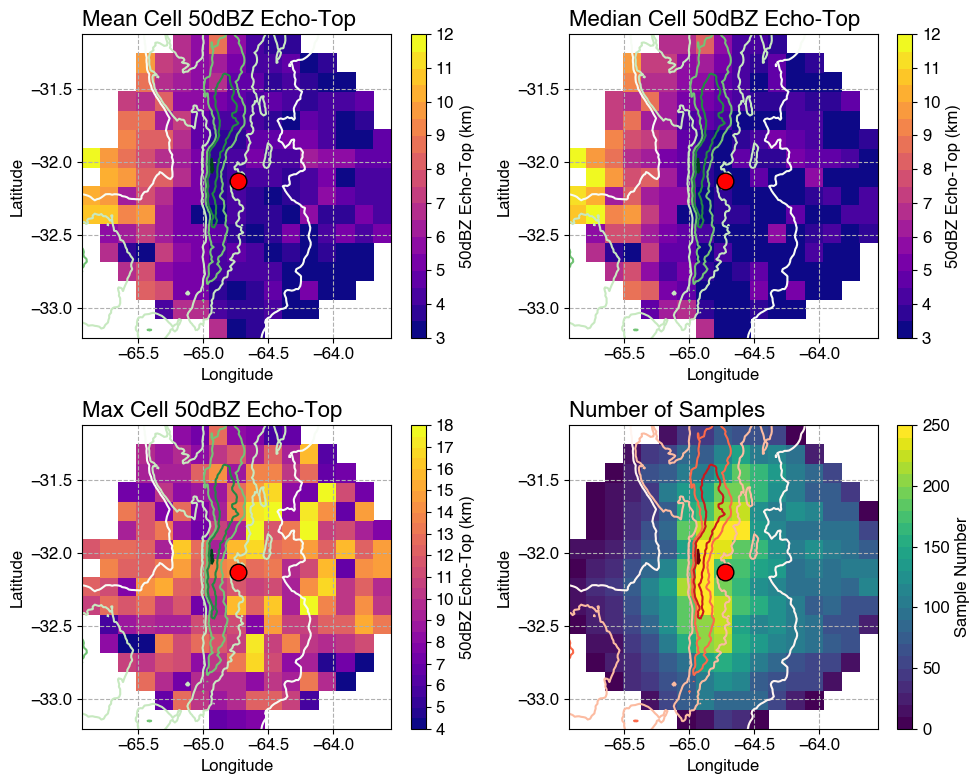

In [121]:
dataarr = [[Mean_ETH50_heatmap, Median_ETH50_heatmap],
           [Max_ETH50_heatmap, Samples_heatmap]]
# levels = [[np.arange(3, 12.1, 0.5), np.arange(3, 12.1, 0.5)], 
#           [np.arange(4, 18.01, 0.5), np.arange(0, 500.1, 10)]]
# cbticks = [[np.arange(3, 12.1, 1), np.arange(3, 12.1, 1)], 
#           [np.arange(4, 18.01, 1), np.arange(0, 500.1, 50)]]
levels = [[np.arange(3, 12.1, 0.5), np.arange(3, 12.1, 0.5)], 
          [np.arange(4, 18.1, 0.5), np.arange(0, 250.1, 10)]]
cbticks = [[np.arange(3, 12.1, 1), np.arange(3, 12.1, 1)], 
          [np.arange(4, 18.1, 1), np.arange(0, 250.1, 50)]]
cmaps = [['plasma', 'plasma'], 
         ['plasma', 'viridis']]
cmap_topo = [['Greens', 'Greens'], ['Greens', 'Reds']]
titles = [['Mean Cell 50dBZ Echo-Top', 'Median Cell 50dBZ Echo-Top'],
          ['Max Cell 50dBZ Echo-Top', 'Number of Samples']]
cblabels = [['50dBZ Echo-Top (km)', '50dBZ Echo-Top (km)'],
            ['50dBZ Echo-Top (km)', 'Sample Number']]
figname = f'{figdir}mean_median_max_cell_50dBZ_ETH_loc_0.2deg.png'
fig = plot_4heatmaps(dataarr, lonbins, latbins, topoZ, topoLon, topoLat, levels, cmaps, cmap_topo, titles, cblabels, cbticks, figname)

In [262]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'